# Creating a DQN LSTM Agent

In [ ]:
%matplotlib inline

import sys
import gym
import torch
import pylab
import random
import numpy as np
from collections import deque
from datetime import datetime
from copy import deepcopy
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from utils import find_max_lives, check_live, get_frame, get_init_state
from model import DQN, DQN_LSTM
from config import *

import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
env = gym.make('BreakoutDeterministic-v4')
state = env.reset()

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


In [ ]:
number_lives = find_max_lives(env)
state_size = env.observation_space.shape
action_size = 3 #fire, left, and right

Now we will create a DQN agent that uses LSTM rather than past frames as history. We augment the experience replay to contain previous few (state, action, reward, next state) tuples rather than just one (state, action, reward, next state) tuple so it can work with LSTMs. Use the previous tuples to generate the current hidden and context vector for LSTM.
Esentially, when you get a sample from replay buffer during training, start with the first tuple and generate hidden and context vector from this and pass it onto the next tuple. Do so consequitively till you reach the last tuple, where you will make Q value predictions.
Training loop remains nearly the same.

In [ ]:
from agent_lstm import Agent_LSTM
agent = Agent_LSTM(action_size)
evaluation_reward = deque(maxlen=evaluation_reward_length)
frame = 0
memory_size = 0

In [ ]:
EPISODES = 20000
print(EPISODES)

20000


In [ ]:
# num_layer = 3
HISTORY_SIZE = 1
rewards, episodes = [], []
best_eval_reward = 0
halt_flag = 0

for e in range(EPISODES):
    done = False
    score = 0

    history = np.zeros([HISTORY_SIZE + 1, 84, 84], dtype=np.uint8)
    step = 0
    state, _ = env.reset()
    next_state = state
    life = number_lives
    hidden = None

    get_init_state(history, state, HISTORY_SIZE)

    while not done:
        step += 1
        frame += 1

        # Perform a fire action if ball is no longer on screen to continue onto next life
        if step > 1 and len(np.unique(next_state[:189] == state[:189])) < 2:
            action = torch.tensor([[0]]).cuda()
        else:
            action, hidden = agent.get_action(np.float32(history[:1, :, :]) / 255., hidden)
        state = next_state
        next_state, reward, terminated, truncated, info = env.step(action + 1)
        done = terminated or truncated

        frame_next_state = get_frame(next_state)
        history[1, :, :] = frame_next_state
        terminal_state = check_live(life, info['lives'])

        life = info['lives']
        r = reward

        # Store the transition in memory
        agent.memory.push(deepcopy(frame_next_state), action.cpu(), r, terminal_state)
        # Start training after random sample generation
        if(frame >= train_frame):
            agent.train_policy_net(frame)
        score += reward
        history[:1, :, :] = history[1:, :, :]

        if done:
            evaluation_reward.append(score)
            rewards.append(np.mean(evaluation_reward))
            episodes.append(e)
            pylab.plot(episodes, rewards, 'b')
            pylab.xlabel('Episodes')
            pylab.ylabel('Rewards')
            pylab.title('Episodes vs Reward')
            pylab.savefig("./save_graph/breakout_dqn_lstm.png") # save graph for training visualization

            # every episode, plot the play time
            print("episode:", e, "  score:", score, "  memory length:",
                  len(agent.memory), "  epsilon:", agent.epsilon, "   steps:", step,
                  "   lr:", agent.optimizer.param_groups[0]['lr'], "    evaluation reward:", np.mean(evaluation_reward))

            # if the mean of scores of last 100 episode is bigger than 8 save model
            ### Change this save condition to whatever you prefer ###
            if np.mean(evaluation_reward) > 8.0 and np.mean(evaluation_reward) > best_eval_reward:
                torch.save(agent.policy_net, "./save_model/breakout_dqn_lstm.pth")
                best_eval_reward = np.mean(evaluation_reward)
                if np.mean(evaluation_reward) > 8.2:
                    halt_flag = 1
                    break
    if halt_flag == 1:
        break


episode: 0   score: 0.0   memory length: 123   epsilon: 1.0    steps: 123    lr: 0.0001     evaluation reward: 0.0
episode: 1   score: 2.0   memory length: 321   epsilon: 1.0    steps: 198    lr: 0.0001     evaluation reward: 1.0
episode: 2   score: 0.0   memory length: 444   epsilon: 1.0    steps: 123    lr: 0.0001     evaluation reward: 0.6666666666666666
episode: 3   score: 3.0   memory length: 709   epsilon: 1.0    steps: 265    lr: 0.0001     evaluation reward: 1.25
episode: 4   score: 4.0   memory length: 968   epsilon: 1.0    steps: 259    lr: 0.0001     evaluation reward: 1.8
episode: 5   score: 0.0   memory length: 1091   epsilon: 1.0    steps: 123    lr: 0.0001     evaluation reward: 1.5
episode: 6   score: 1.0   memory length: 1261   epsilon: 1.0    steps: 170    lr: 0.0001     evaluation reward: 1.4285714285714286
episode: 7   score: 3.0   memory length: 1507   epsilon: 1.0    steps: 246    lr: 0.0001     evaluation reward: 1.625
episode: 8   score: 1.0   memory length: 167

episode: 65   score: 2.0   memory length: 11761   epsilon: 1.0    steps: 198    lr: 0.0001     evaluation reward: 1.3484848484848484
episode: 66   score: 4.0   memory length: 12075   epsilon: 1.0    steps: 314    lr: 0.0001     evaluation reward: 1.3880597014925373
episode: 67   score: 2.0   memory length: 12274   epsilon: 1.0    steps: 199    lr: 0.0001     evaluation reward: 1.3970588235294117
episode: 68   score: 4.0   memory length: 12528   epsilon: 1.0    steps: 254    lr: 0.0001     evaluation reward: 1.434782608695652
episode: 69   score: 2.0   memory length: 12708   epsilon: 1.0    steps: 180    lr: 0.0001     evaluation reward: 1.4428571428571428
episode: 70   score: 2.0   memory length: 12907   epsilon: 1.0    steps: 199    lr: 0.0001     evaluation reward: 1.4507042253521127
episode: 71   score: 1.0   memory length: 13075   epsilon: 1.0    steps: 168    lr: 0.0001     evaluation reward: 1.4444444444444444
episode: 72   score: 4.0   memory length: 13340   epsilon: 1.0    step

episode: 130   score: 1.0   memory length: 23423   epsilon: 1.0    steps: 152    lr: 0.0001     evaluation reward: 1.4
episode: 131   score: 4.0   memory length: 23679   epsilon: 1.0    steps: 256    lr: 0.0001     evaluation reward: 1.44
episode: 132   score: 0.0   memory length: 23802   epsilon: 1.0    steps: 123    lr: 0.0001     evaluation reward: 1.4
episode: 133   score: 2.0   memory length: 23999   epsilon: 1.0    steps: 197    lr: 0.0001     evaluation reward: 1.42
episode: 134   score: 0.0   memory length: 24122   epsilon: 1.0    steps: 123    lr: 0.0001     evaluation reward: 1.4
episode: 135   score: 4.0   memory length: 24401   epsilon: 1.0    steps: 279    lr: 0.0001     evaluation reward: 1.43
episode: 136   score: 4.0   memory length: 24714   epsilon: 1.0    steps: 313    lr: 0.0001     evaluation reward: 1.44
episode: 137   score: 0.0   memory length: 24836   epsilon: 1.0    steps: 122    lr: 0.0001     evaluation reward: 1.44
episode: 138   score: 0.0   memory length: 

episode: 199   score: 1.0   memory length: 35570   epsilon: 1.0    steps: 171    lr: 0.0001     evaluation reward: 1.35
episode: 200   score: 0.0   memory length: 35693   epsilon: 1.0    steps: 123    lr: 0.0001     evaluation reward: 1.35
episode: 201   score: 3.0   memory length: 35936   epsilon: 1.0    steps: 243    lr: 0.0001     evaluation reward: 1.35
episode: 202   score: 4.0   memory length: 36230   epsilon: 1.0    steps: 294    lr: 0.0001     evaluation reward: 1.38
episode: 203   score: 5.0   memory length: 36527   epsilon: 1.0    steps: 297    lr: 0.0001     evaluation reward: 1.43
episode: 204   score: 1.0   memory length: 36677   epsilon: 1.0    steps: 150    lr: 0.0001     evaluation reward: 1.41
episode: 205   score: 0.0   memory length: 36799   epsilon: 1.0    steps: 122    lr: 0.0001     evaluation reward: 1.39
episode: 206   score: 0.0   memory length: 36922   epsilon: 1.0    steps: 123    lr: 0.0001     evaluation reward: 1.39
episode: 207   score: 3.0   memory lengt

episode: 268   score: 4.0   memory length: 47977   epsilon: 1.0    steps: 297    lr: 0.0001     evaluation reward: 1.29
episode: 269   score: 1.0   memory length: 48128   epsilon: 1.0    steps: 151    lr: 0.0001     evaluation reward: 1.29
episode: 270   score: 0.0   memory length: 48250   epsilon: 1.0    steps: 122    lr: 0.0001     evaluation reward: 1.29
episode: 271   score: 1.0   memory length: 48418   epsilon: 1.0    steps: 168    lr: 0.0001     evaluation reward: 1.3
episode: 272   score: 0.0   memory length: 48540   epsilon: 1.0    steps: 122    lr: 0.0001     evaluation reward: 1.3
episode: 273   score: 2.0   memory length: 48722   epsilon: 1.0    steps: 182    lr: 0.0001     evaluation reward: 1.3
episode: 274   score: 3.0   memory length: 48953   epsilon: 1.0    steps: 231    lr: 0.0001     evaluation reward: 1.33
episode: 275   score: 1.0   memory length: 49103   epsilon: 1.0    steps: 150    lr: 0.0001     evaluation reward: 1.34
episode: 276   score: 3.0   memory length: 

episode: 337   score: 0.0   memory length: 60048   epsilon: 1.0    steps: 123    lr: 0.0001     evaluation reward: 1.24
episode: 338   score: 1.0   memory length: 60216   epsilon: 1.0    steps: 168    lr: 0.0001     evaluation reward: 1.25
episode: 339   score: 1.0   memory length: 60388   epsilon: 1.0    steps: 172    lr: 0.0001     evaluation reward: 1.25
episode: 340   score: 4.0   memory length: 60682   epsilon: 1.0    steps: 294    lr: 0.0001     evaluation reward: 1.29
episode: 341   score: 2.0   memory length: 60882   epsilon: 1.0    steps: 200    lr: 0.0001     evaluation reward: 1.31
episode: 342   score: 2.0   memory length: 61068   epsilon: 1.0    steps: 186    lr: 0.0001     evaluation reward: 1.33
episode: 343   score: 0.0   memory length: 61190   epsilon: 1.0    steps: 122    lr: 0.0001     evaluation reward: 1.3
episode: 344   score: 1.0   memory length: 61362   epsilon: 1.0    steps: 172    lr: 0.0001     evaluation reward: 1.28
episode: 345   score: 0.0   memory length

episode: 406   score: 2.0   memory length: 73023   epsilon: 1.0    steps: 198    lr: 0.0001     evaluation reward: 1.55
episode: 407   score: 1.0   memory length: 73193   epsilon: 1.0    steps: 170    lr: 0.0001     evaluation reward: 1.56
episode: 408   score: 4.0   memory length: 73488   epsilon: 1.0    steps: 295    lr: 0.0001     evaluation reward: 1.6
episode: 409   score: 3.0   memory length: 73716   epsilon: 1.0    steps: 228    lr: 0.0001     evaluation reward: 1.62
episode: 410   score: 1.0   memory length: 73884   epsilon: 1.0    steps: 168    lr: 0.0001     evaluation reward: 1.62
episode: 411   score: 2.0   memory length: 74101   epsilon: 1.0    steps: 217    lr: 0.0001     evaluation reward: 1.63
episode: 412   score: 2.0   memory length: 74317   epsilon: 1.0    steps: 216    lr: 0.0001     evaluation reward: 1.64
episode: 413   score: 5.0   memory length: 74664   epsilon: 1.0    steps: 347    lr: 0.0001     evaluation reward: 1.69
episode: 414   score: 1.0   memory length

episode: 475   score: 4.0   memory length: 85890   epsilon: 1.0    steps: 277    lr: 0.0001     evaluation reward: 1.68
episode: 476   score: 0.0   memory length: 86013   epsilon: 1.0    steps: 123    lr: 0.0001     evaluation reward: 1.65
episode: 477   score: 0.0   memory length: 86135   epsilon: 1.0    steps: 122    lr: 0.0001     evaluation reward: 1.61
episode: 478   score: 0.0   memory length: 86258   epsilon: 1.0    steps: 123    lr: 0.0001     evaluation reward: 1.59
episode: 479   score: 2.0   memory length: 86456   epsilon: 1.0    steps: 198    lr: 0.0001     evaluation reward: 1.54
episode: 480   score: 1.0   memory length: 86625   epsilon: 1.0    steps: 169    lr: 0.0001     evaluation reward: 1.54
episode: 481   score: 3.0   memory length: 86853   epsilon: 1.0    steps: 228    lr: 0.0001     evaluation reward: 1.55
episode: 482   score: 3.0   memory length: 87079   epsilon: 1.0    steps: 226    lr: 0.0001     evaluation reward: 1.54
episode: 483   score: 0.0   memory lengt

episode: 544   score: 0.0   memory length: 97957   epsilon: 1.0    steps: 123    lr: 0.0001     evaluation reward: 1.47
episode: 545   score: 3.0   memory length: 98206   epsilon: 1.0    steps: 249    lr: 0.0001     evaluation reward: 1.48
episode: 546   score: 0.0   memory length: 98328   epsilon: 1.0    steps: 122    lr: 0.0001     evaluation reward: 1.47
episode: 547   score: 2.0   memory length: 98546   epsilon: 1.0    steps: 218    lr: 0.0001     evaluation reward: 1.45
episode: 548   score: 4.0   memory length: 98839   epsilon: 1.0    steps: 293    lr: 0.0001     evaluation reward: 1.46
episode: 549   score: 2.0   memory length: 99021   epsilon: 1.0    steps: 182    lr: 0.0001     evaluation reward: 1.46
episode: 550   score: 2.0   memory length: 99238   epsilon: 1.0    steps: 217    lr: 0.0001     evaluation reward: 1.47
episode: 551   score: 0.0   memory length: 99360   epsilon: 1.0    steps: 122    lr: 0.0001     evaluation reward: 1.47
episode: 552   score: 1.0   memory lengt

/u/qilong/QA_generator/CS444/mp5/memory.py:66: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  sample = np.array(sample, dtype=object)
/u/qilong/QA_generator/CS444/mp5/agent_lstm.py:53: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array create

episode: 555   score: 3.0   memory length: 100081   epsilon: 0.9998376400000035    steps: 230    lr: 0.0001     evaluation reward: 1.46
episode: 556   score: 3.0   memory length: 100327   epsilon: 0.9993505600000141    steps: 246    lr: 0.0001     evaluation reward: 1.49
episode: 557   score: 3.0   memory length: 100576   epsilon: 0.9988575400000248    steps: 249    lr: 0.0001     evaluation reward: 1.52
episode: 558   score: 1.0   memory length: 100744   epsilon: 0.998524900000032    steps: 168    lr: 0.0001     evaluation reward: 1.53
episode: 559   score: 2.0   memory length: 100942   epsilon: 0.9981328600000405    steps: 198    lr: 0.0001     evaluation reward: 1.53
episode: 560   score: 0.0   memory length: 101065   epsilon: 0.9978893200000458    steps: 123    lr: 0.0001     evaluation reward: 1.53
episode: 561   score: 4.0   memory length: 101385   epsilon: 0.9972557200000596    steps: 320    lr: 0.0001     evaluation reward: 1.53
episode: 562   score: 0.0   memory length: 101507

episode: 616   score: 2.0   memory length: 111467   epsilon: 0.9772933600004929    steps: 182    lr: 0.0001     evaluation reward: 1.5
episode: 617   score: 1.0   memory length: 111635   epsilon: 0.9769607200005002    steps: 168    lr: 0.0001     evaluation reward: 1.47
episode: 618   score: 1.0   memory length: 111805   epsilon: 0.9766241200005075    steps: 170    lr: 0.0001     evaluation reward: 1.48
episode: 619   score: 2.0   memory length: 112003   epsilon: 0.976232080000516    steps: 198    lr: 0.0001     evaluation reward: 1.49
episode: 620   score: 3.0   memory length: 112270   epsilon: 0.9757034200005275    steps: 267    lr: 0.0001     evaluation reward: 1.5
episode: 621   score: 0.0   memory length: 112392   epsilon: 0.9754618600005327    steps: 122    lr: 0.0001     evaluation reward: 1.46
episode: 622   score: 0.0   memory length: 112515   epsilon: 0.975218320000538    steps: 123    lr: 0.0001     evaluation reward: 1.45
episode: 623   score: 0.0   memory length: 112638   

episode: 677   score: 6.0   memory length: 122780   epsilon: 0.9548936200009792    steps: 327    lr: 0.0001     evaluation reward: 1.53
episode: 678   score: 1.0   memory length: 122932   epsilon: 0.9545926600009857    steps: 152    lr: 0.0001     evaluation reward: 1.52
episode: 679   score: 0.0   memory length: 123054   epsilon: 0.954351100000991    steps: 122    lr: 0.0001     evaluation reward: 1.49
episode: 680   score: 2.0   memory length: 123271   epsilon: 0.9539214400010003    steps: 217    lr: 0.0001     evaluation reward: 1.5
episode: 681   score: 2.0   memory length: 123474   epsilon: 0.953519500001009    steps: 203    lr: 0.0001     evaluation reward: 1.51
episode: 682   score: 4.0   memory length: 123768   epsilon: 0.9529373800010217    steps: 294    lr: 0.0001     evaluation reward: 1.54
episode: 683   score: 0.0   memory length: 123891   epsilon: 0.952693840001027    steps: 123    lr: 0.0001     evaluation reward: 1.53
episode: 684   score: 2.0   memory length: 124089   

episode: 738   score: 2.0   memory length: 134679   epsilon: 0.9313336000014907    steps: 218    lr: 0.0001     evaluation reward: 1.75
episode: 739   score: 2.0   memory length: 134877   epsilon: 0.9309415600014992    steps: 198    lr: 0.0001     evaluation reward: 1.75
episode: 740   score: 2.0   memory length: 135095   epsilon: 0.9305099200015086    steps: 218    lr: 0.0001     evaluation reward: 1.77
episode: 741   score: 4.0   memory length: 135391   epsilon: 0.9299238400015213    steps: 296    lr: 0.0001     evaluation reward: 1.79
episode: 742   score: 1.0   memory length: 135559   epsilon: 0.9295912000015285    steps: 168    lr: 0.0001     evaluation reward: 1.77
episode: 743   score: 4.0   memory length: 135833   epsilon: 0.9290486800015403    steps: 274    lr: 0.0001     evaluation reward: 1.77
episode: 744   score: 9.0   memory length: 136222   epsilon: 0.928278460001557    steps: 389    lr: 0.0001     evaluation reward: 1.86
episode: 745   score: 2.0   memory length: 136438

episode: 799   score: 2.0   memory length: 146445   epsilon: 0.9080369200019964    steps: 198    lr: 0.0001     evaluation reward: 1.69
episode: 800   score: 0.0   memory length: 146568   epsilon: 0.9077933800020017    steps: 123    lr: 0.0001     evaluation reward: 1.68
episode: 801   score: 2.0   memory length: 146766   epsilon: 0.9074013400020102    steps: 198    lr: 0.0001     evaluation reward: 1.7
episode: 802   score: 4.0   memory length: 147044   epsilon: 0.9068509000020222    steps: 278    lr: 0.0001     evaluation reward: 1.74
episode: 803   score: 2.0   memory length: 147260   epsilon: 0.9064232200020315    steps: 216    lr: 0.0001     evaluation reward: 1.74
episode: 804   score: 2.0   memory length: 147461   epsilon: 0.9060252400020401    steps: 201    lr: 0.0001     evaluation reward: 1.75
episode: 805   score: 0.0   memory length: 147583   epsilon: 0.9057836800020453    steps: 122    lr: 0.0001     evaluation reward: 1.75
episode: 806   score: 2.0   memory length: 147798

episode: 860   score: 3.0   memory length: 158456   epsilon: 0.8842551400025127    steps: 248    lr: 0.0001     evaluation reward: 1.78
episode: 861   score: 2.0   memory length: 158654   epsilon: 0.8838631000025212    steps: 198    lr: 0.0001     evaluation reward: 1.76
episode: 862   score: 3.0   memory length: 158898   epsilon: 0.8833799800025317    steps: 244    lr: 0.0001     evaluation reward: 1.79
episode: 863   score: 2.0   memory length: 159095   epsilon: 0.8829899200025402    steps: 197    lr: 0.0001     evaluation reward: 1.8
episode: 864   score: 0.0   memory length: 159218   epsilon: 0.8827463800025455    steps: 123    lr: 0.0001     evaluation reward: 1.77
episode: 865   score: 2.0   memory length: 159416   epsilon: 0.882354340002554    steps: 198    lr: 0.0001     evaluation reward: 1.74
episode: 866   score: 5.0   memory length: 159718   epsilon: 0.881756380002567    steps: 302    lr: 0.0001     evaluation reward: 1.77
episode: 867   score: 3.0   memory length: 159989  

episode: 921   score: 1.0   memory length: 169648   epsilon: 0.8620949800029938    steps: 151    lr: 0.0001     evaluation reward: 1.69
episode: 922   score: 0.0   memory length: 169771   epsilon: 0.8618514400029991    steps: 123    lr: 0.0001     evaluation reward: 1.67
episode: 923   score: 0.0   memory length: 169894   epsilon: 0.8616079000030044    steps: 123    lr: 0.0001     evaluation reward: 1.67
episode: 924   score: 1.0   memory length: 170066   epsilon: 0.8612673400030117    steps: 172    lr: 0.0001     evaluation reward: 1.67
episode: 925   score: 6.0   memory length: 170463   epsilon: 0.8604812800030288    steps: 397    lr: 0.0001     evaluation reward: 1.71
episode: 926   score: 0.0   memory length: 170585   epsilon: 0.8602397200030341    steps: 122    lr: 0.0001     evaluation reward: 1.68
episode: 927   score: 0.0   memory length: 170708   epsilon: 0.8599961800030393    steps: 123    lr: 0.0001     evaluation reward: 1.66
episode: 928   score: 3.0   memory length: 17095

episode: 982   score: 5.0   memory length: 181348   epsilon: 0.8389289800034967    steps: 326    lr: 0.0001     evaluation reward: 1.64
episode: 983   score: 4.0   memory length: 181644   epsilon: 0.8383429000035094    steps: 296    lr: 0.0001     evaluation reward: 1.67
episode: 984   score: 2.0   memory length: 181841   epsilon: 0.8379528400035179    steps: 197    lr: 0.0001     evaluation reward: 1.67
episode: 985   score: 1.0   memory length: 181992   epsilon: 0.8376538600035244    steps: 151    lr: 0.0001     evaluation reward: 1.67
episode: 986   score: 2.0   memory length: 182208   epsilon: 0.8372261800035337    steps: 216    lr: 0.0001     evaluation reward: 1.67
episode: 987   score: 3.0   memory length: 182434   epsilon: 0.8367787000035434    steps: 226    lr: 0.0001     evaluation reward: 1.67
episode: 988   score: 2.0   memory length: 182632   epsilon: 0.8363866600035519    steps: 198    lr: 0.0001     evaluation reward: 1.69
episode: 989   score: 3.0   memory length: 18285

episode: 1042   score: 4.0   memory length: 193998   epsilon: 0.8138819800040404    steps: 316    lr: 0.0001     evaluation reward: 1.98
episode: 1043   score: 0.0   memory length: 194121   epsilon: 0.8136384400040457    steps: 123    lr: 0.0001     evaluation reward: 1.97
episode: 1044   score: 1.0   memory length: 194290   epsilon: 0.813303820004053    steps: 169    lr: 0.0001     evaluation reward: 1.95
episode: 1045   score: 3.0   memory length: 194516   epsilon: 0.8128563400040627    steps: 226    lr: 0.0001     evaluation reward: 1.97
episode: 1046   score: 2.0   memory length: 194714   epsilon: 0.8124643000040712    steps: 198    lr: 0.0001     evaluation reward: 1.99
episode: 1047   score: 4.0   memory length: 194989   epsilon: 0.811919800004083    steps: 275    lr: 0.0001     evaluation reward: 2.01
episode: 1048   score: 1.0   memory length: 195140   epsilon: 0.8116208200040895    steps: 151    lr: 0.0001     evaluation reward: 2.0
episode: 1049   score: 1.0   memory length: 

episode: 1102   score: 1.0   memory length: 207036   epsilon: 0.7880667400046009    steps: 170    lr: 0.0001     evaluation reward: 2.35
episode: 1103   score: 0.0   memory length: 207159   epsilon: 0.7878232000046062    steps: 123    lr: 0.0001     evaluation reward: 2.33
episode: 1104   score: 4.0   memory length: 207473   epsilon: 0.7872014800046196    steps: 314    lr: 0.0001     evaluation reward: 2.34
episode: 1105   score: 3.0   memory length: 207743   epsilon: 0.7866668800046313    steps: 270    lr: 0.0001     evaluation reward: 2.35
episode: 1106   score: 4.0   memory length: 208021   epsilon: 0.7861164400046432    steps: 278    lr: 0.0001     evaluation reward: 2.36
episode: 1107   score: 3.0   memory length: 208246   epsilon: 0.7856709400046529    steps: 225    lr: 0.0001     evaluation reward: 2.36
episode: 1108   score: 4.0   memory length: 208533   epsilon: 0.7851026800046652    steps: 287    lr: 0.0001     evaluation reward: 2.38
episode: 1109   score: 2.0   memory lengt

episode: 1162   score: 2.0   memory length: 219552   epsilon: 0.7632850600051388    steps: 221    lr: 0.0001     evaluation reward: 2.38
episode: 1163   score: 2.0   memory length: 219750   epsilon: 0.7628930200051474    steps: 198    lr: 0.0001     evaluation reward: 2.36
episode: 1164   score: 4.0   memory length: 220048   epsilon: 0.7623029800051602    steps: 298    lr: 0.0001     evaluation reward: 2.37
episode: 1165   score: 5.0   memory length: 220375   epsilon: 0.7616555200051742    steps: 327    lr: 0.0001     evaluation reward: 2.4
episode: 1166   score: 1.0   memory length: 220525   epsilon: 0.7613585200051807    steps: 150    lr: 0.0001     evaluation reward: 2.41
episode: 1167   score: 1.0   memory length: 220693   epsilon: 0.7610258800051879    steps: 168    lr: 0.0001     evaluation reward: 2.38
episode: 1168   score: 8.0   memory length: 221137   epsilon: 0.760146760005207    steps: 444    lr: 0.0001     evaluation reward: 2.44
episode: 1169   score: 2.0   memory length:

episode: 1222   score: 4.0   memory length: 233134   epsilon: 0.7363927000057227    steps: 316    lr: 0.0001     evaluation reward: 2.35
episode: 1223   score: 2.0   memory length: 233331   epsilon: 0.7360026400057311    steps: 197    lr: 0.0001     evaluation reward: 2.37
episode: 1224   score: 3.0   memory length: 233578   epsilon: 0.7355135800057417    steps: 247    lr: 0.0001     evaluation reward: 2.36
episode: 1225   score: 2.0   memory length: 233778   epsilon: 0.7351175800057503    steps: 200    lr: 0.0001     evaluation reward: 2.36
episode: 1226   score: 2.0   memory length: 233975   epsilon: 0.7347275200057588    steps: 197    lr: 0.0001     evaluation reward: 2.34
episode: 1227   score: 4.0   memory length: 234251   epsilon: 0.7341810400057707    steps: 276    lr: 0.0001     evaluation reward: 2.35
episode: 1228   score: 1.0   memory length: 234402   epsilon: 0.7338820600057772    steps: 151    lr: 0.0001     evaluation reward: 2.32
episode: 1229   score: 3.0   memory lengt

episode: 1282   score: 2.0   memory length: 247154   epsilon: 0.7086331000063253    steps: 202    lr: 0.0001     evaluation reward: 2.74
episode: 1283   score: 0.0   memory length: 247276   epsilon: 0.7083915400063305    steps: 122    lr: 0.0001     evaluation reward: 2.69
episode: 1284   score: 3.0   memory length: 247486   epsilon: 0.7079757400063396    steps: 210    lr: 0.0001     evaluation reward: 2.69
episode: 1285   score: 4.0   memory length: 247780   epsilon: 0.7073936200063522    steps: 294    lr: 0.0001     evaluation reward: 2.71
episode: 1286   score: 4.0   memory length: 248073   epsilon: 0.7068134800063648    steps: 293    lr: 0.0001     evaluation reward: 2.72
episode: 1287   score: 2.0   memory length: 248255   epsilon: 0.7064531200063726    steps: 182    lr: 0.0001     evaluation reward: 2.71
episode: 1288   score: 2.0   memory length: 248452   epsilon: 0.7060630600063811    steps: 197    lr: 0.0001     evaluation reward: 2.68
episode: 1289   score: 3.0   memory lengt

episode: 1342   score: 4.0   memory length: 261620   epsilon: 0.6799904200069471    steps: 259    lr: 0.0001     evaluation reward: 2.98
episode: 1343   score: 3.0   memory length: 261846   epsilon: 0.6795429400069568    steps: 226    lr: 0.0001     evaluation reward: 2.99
episode: 1344   score: 2.0   memory length: 262044   epsilon: 0.6791509000069653    steps: 198    lr: 0.0001     evaluation reward: 2.98
episode: 1345   score: 4.0   memory length: 262319   epsilon: 0.6786064000069771    steps: 275    lr: 0.0001     evaluation reward: 2.97
episode: 1346   score: 1.0   memory length: 262469   epsilon: 0.6783094000069836    steps: 150    lr: 0.0001     evaluation reward: 2.96
episode: 1347   score: 2.0   memory length: 262667   epsilon: 0.6779173600069921    steps: 198    lr: 0.0001     evaluation reward: 2.96
episode: 1348   score: 1.0   memory length: 262818   epsilon: 0.6776183800069986    steps: 151    lr: 0.0001     evaluation reward: 2.93
episode: 1349   score: 4.0   memory lengt

episode: 1402   score: 3.0   memory length: 276247   epsilon: 0.6510289600075758    steps: 211    lr: 0.0001     evaluation reward: 3.16
episode: 1403   score: 5.0   memory length: 276548   epsilon: 0.6504329800075888    steps: 301    lr: 0.0001     evaluation reward: 3.16
episode: 1404   score: 6.0   memory length: 276884   epsilon: 0.6497677000076032    steps: 336    lr: 0.0001     evaluation reward: 3.2
episode: 1405   score: 4.0   memory length: 277142   epsilon: 0.6492568600076143    steps: 258    lr: 0.0001     evaluation reward: 3.22
episode: 1406   score: 4.0   memory length: 277438   epsilon: 0.648670780007627    steps: 296    lr: 0.0001     evaluation reward: 3.24
episode: 1407   score: 5.0   memory length: 277733   epsilon: 0.6480866800076397    steps: 295    lr: 0.0001     evaluation reward: 3.26
episode: 1408   score: 1.0   memory length: 277905   epsilon: 0.6477461200076471    steps: 172    lr: 0.0001     evaluation reward: 3.22
episode: 1409   score: 2.0   memory length:

episode: 1462   score: 2.0   memory length: 290727   epsilon: 0.6223585600081982    steps: 181    lr: 0.0001     evaluation reward: 3.28
episode: 1463   score: 4.0   memory length: 291014   epsilon: 0.6217903000082106    steps: 287    lr: 0.0001     evaluation reward: 3.29
episode: 1464   score: 3.0   memory length: 291224   epsilon: 0.6213745000082196    steps: 210    lr: 0.0001     evaluation reward: 3.29
episode: 1465   score: 5.0   memory length: 291527   epsilon: 0.6207745600082326    steps: 303    lr: 0.0001     evaluation reward: 3.31
episode: 1466   score: 4.0   memory length: 291823   epsilon: 0.6201884800082453    steps: 296    lr: 0.0001     evaluation reward: 3.31
episode: 1467   score: 5.0   memory length: 292166   epsilon: 0.6195093400082601    steps: 343    lr: 0.0001     evaluation reward: 3.33
episode: 1468   score: 1.0   memory length: 292335   epsilon: 0.6191747200082673    steps: 169    lr: 0.0001     evaluation reward: 3.33
episode: 1469   score: 5.0   memory lengt

episode: 1537   score: 3.0   memory length: 310441   epsilon: 0.5833248400090456    steps: 228    lr: 0.0001     evaluation reward: 3.65
episode: 1538   score: 4.0   memory length: 310707   epsilon: 0.582798160009057    steps: 266    lr: 0.0001     evaluation reward: 3.66
episode: 1539   score: 3.0   memory length: 310935   epsilon: 0.5823467200090668    steps: 228    lr: 0.0001     evaluation reward: 3.66
episode: 1540   score: 7.0   memory length: 311310   epsilon: 0.581604220009083    steps: 375    lr: 0.0001     evaluation reward: 3.68
episode: 1541   score: 3.0   memory length: 311536   epsilon: 0.5811567400090927    steps: 226    lr: 0.0001     evaluation reward: 3.65
episode: 1542   score: 2.0   memory length: 311734   epsilon: 0.5807647000091012    steps: 198    lr: 0.0001     evaluation reward: 3.64
episode: 1543   score: 4.0   memory length: 311981   epsilon: 0.5802756400091118    steps: 247    lr: 0.0001     evaluation reward: 3.63
episode: 1544   score: 3.0   memory length:

episode: 1597   score: 4.0   memory length: 326276   epsilon: 0.5519715400097263    steps: 257    lr: 0.0001     evaluation reward: 3.72
episode: 1598   score: 6.0   memory length: 326615   epsilon: 0.5513003200097408    steps: 339    lr: 0.0001     evaluation reward: 3.75
episode: 1599   score: 7.0   memory length: 327009   epsilon: 0.5505202000097578    steps: 394    lr: 0.0001     evaluation reward: 3.79
episode: 1600   score: 1.0   memory length: 327177   epsilon: 0.550187560009765    steps: 168    lr: 0.0001     evaluation reward: 3.75
episode: 1601   score: 8.0   memory length: 327597   epsilon: 0.549355960009783    steps: 420    lr: 0.0001     evaluation reward: 3.8
episode: 1602   score: 2.0   memory length: 327796   epsilon: 0.5489619400097916    steps: 199    lr: 0.0001     evaluation reward: 3.76
episode: 1603   score: 7.0   memory length: 328045   epsilon: 0.5484689200098023    steps: 249    lr: 0.0001     evaluation reward: 3.79
episode: 1604   score: 3.0   memory length: 

episode: 1657   score: 8.0   memory length: 341565   epsilon: 0.5216993200103834    steps: 294    lr: 0.0001     evaluation reward: 3.76
episode: 1658   score: 3.0   memory length: 341811   epsilon: 0.521212240010394    steps: 246    lr: 0.0001     evaluation reward: 3.75
episode: 1659   score: 4.0   memory length: 342085   epsilon: 0.5206697200104058    steps: 274    lr: 0.0001     evaluation reward: 3.77
episode: 1660   score: 3.0   memory length: 342311   epsilon: 0.5202222400104155    steps: 226    lr: 0.0001     evaluation reward: 3.78
episode: 1661   score: 3.0   memory length: 342536   epsilon: 0.5197767400104252    steps: 225    lr: 0.0001     evaluation reward: 3.77
episode: 1662   score: 2.0   memory length: 342716   epsilon: 0.5194203400104329    steps: 180    lr: 0.0001     evaluation reward: 3.75
episode: 1663   score: 2.0   memory length: 342897   epsilon: 0.5190619600104407    steps: 181    lr: 0.0001     evaluation reward: 3.75
episode: 1664   score: 3.0   memory length

episode: 1717   score: 3.0   memory length: 355992   epsilon: 0.49313386001081105    steps: 212    lr: 0.0001     evaluation reward: 3.31
episode: 1718   score: 4.0   memory length: 356266   epsilon: 0.4925913400108076    steps: 274    lr: 0.0001     evaluation reward: 3.28
episode: 1719   score: 4.0   memory length: 356521   epsilon: 0.4920864400108044    steps: 255    lr: 0.0001     evaluation reward: 3.27
episode: 1720   score: 3.0   memory length: 356730   epsilon: 0.4916726200108018    steps: 209    lr: 0.0001     evaluation reward: 3.26
episode: 1721   score: 2.0   memory length: 356928   epsilon: 0.49128058001079933    steps: 198    lr: 0.0001     evaluation reward: 3.24
episode: 1722   score: 3.0   memory length: 357174   epsilon: 0.49079350001079625    steps: 246    lr: 0.0001     evaluation reward: 3.24
episode: 1723   score: 7.0   memory length: 357534   epsilon: 0.49008070001079174    steps: 360    lr: 0.0001     evaluation reward: 3.27
episode: 1724   score: 1.0   memory l

episode: 1777   score: 3.0   memory length: 372650   epsilon: 0.4601510200106024    steps: 246    lr: 0.0001     evaluation reward: 3.78
episode: 1778   score: 6.0   memory length: 372971   epsilon: 0.45951544001059835    steps: 321    lr: 0.0001     evaluation reward: 3.79
episode: 1779   score: 3.0   memory length: 373217   epsilon: 0.45902836001059527    steps: 246    lr: 0.0001     evaluation reward: 3.76
episode: 1780   score: 5.0   memory length: 373544   epsilon: 0.4583809000105912    steps: 327    lr: 0.0001     evaluation reward: 3.79
episode: 1781   score: 2.0   memory length: 373741   epsilon: 0.4579908400105887    steps: 197    lr: 0.0001     evaluation reward: 3.79
episode: 1782   score: 4.0   memory length: 374020   epsilon: 0.4574384200105852    steps: 279    lr: 0.0001     evaluation reward: 3.8
episode: 1783   score: 3.0   memory length: 374248   epsilon: 0.45698698001058236    steps: 228    lr: 0.0001     evaluation reward: 3.81
episode: 1784   score: 2.0   memory len

episode: 1837   score: 6.0   memory length: 389156   epsilon: 0.4274691400103956    steps: 343    lr: 0.0001     evaluation reward: 4.16
episode: 1838   score: 5.0   memory length: 389460   epsilon: 0.4268672200103918    steps: 304    lr: 0.0001     evaluation reward: 4.16
episode: 1839   score: 3.0   memory length: 389672   epsilon: 0.42644746001038913    steps: 212    lr: 0.0001     evaluation reward: 4.13
episode: 1840   score: 5.0   memory length: 389995   epsilon: 0.4258079200103851    steps: 323    lr: 0.0001     evaluation reward: 4.12
episode: 1841   score: 5.0   memory length: 390299   epsilon: 0.4252060000103813    steps: 304    lr: 0.0001     evaluation reward: 4.14
episode: 1842   score: 5.0   memory length: 390602   epsilon: 0.4246060600103775    steps: 303    lr: 0.0001     evaluation reward: 4.14
episode: 1843   score: 4.0   memory length: 390860   epsilon: 0.42409522001037425    steps: 258    lr: 0.0001     evaluation reward: 4.16
episode: 1844   score: 6.0   memory len

episode: 1897   score: 2.0   memory length: 406037   epsilon: 0.3940447600101841    steps: 181    lr: 4e-05     evaluation reward: 4.3
episode: 1898   score: 4.0   memory length: 406291   epsilon: 0.39354184001018094    steps: 254    lr: 4e-05     evaluation reward: 4.31
episode: 1899   score: 3.0   memory length: 406504   epsilon: 0.3931201000101783    steps: 213    lr: 4e-05     evaluation reward: 4.28
episode: 1900   score: 8.0   memory length: 406923   epsilon: 0.392290480010173    steps: 419    lr: 4e-05     evaluation reward: 4.32
episode: 1901   score: 6.0   memory length: 407334   epsilon: 0.3914767000101679    steps: 411    lr: 4e-05     evaluation reward: 4.35
episode: 1902   score: 5.0   memory length: 407639   epsilon: 0.39087280001016406    steps: 305    lr: 4e-05     evaluation reward: 4.35
episode: 1903   score: 5.0   memory length: 407946   epsilon: 0.3902649400101602    steps: 307    lr: 4e-05     evaluation reward: 4.38
episode: 1904   score: 3.0   memory length: 4081

episode: 1958   score: 2.0   memory length: 421913   epsilon: 0.36261028000998524    steps: 182    lr: 4e-05     evaluation reward: 3.97
episode: 1959   score: 3.0   memory length: 422143   epsilon: 0.36215488000998236    steps: 230    lr: 4e-05     evaluation reward: 3.97
episode: 1960   score: 6.0   memory length: 422485   epsilon: 0.3614777200099781    steps: 342    lr: 4e-05     evaluation reward: 3.97
episode: 1961   score: 6.0   memory length: 422848   epsilon: 0.36075898000997353    steps: 363    lr: 4e-05     evaluation reward: 3.97
episode: 1962   score: 3.0   memory length: 423073   epsilon: 0.3603134800099707    steps: 225    lr: 4e-05     evaluation reward: 3.95
episode: 1963   score: 3.0   memory length: 423283   epsilon: 0.3598976800099681    steps: 210    lr: 4e-05     evaluation reward: 3.95
episode: 1964   score: 5.0   memory length: 423609   epsilon: 0.359252200009964    steps: 326    lr: 4e-05     evaluation reward: 3.98
episode: 1965   score: 3.0   memory length: 42

episode: 2019   score: 9.0   memory length: 438572   epsilon: 0.32962546000977655    steps: 469    lr: 4e-05     evaluation reward: 3.93
episode: 2020   score: 4.0   memory length: 438815   epsilon: 0.3291443200097735    steps: 243    lr: 4e-05     evaluation reward: 3.94
episode: 2021   score: 2.0   memory length: 438997   epsilon: 0.3287839600097712    steps: 182    lr: 4e-05     evaluation reward: 3.89
episode: 2022   score: 5.0   memory length: 439323   epsilon: 0.32813848000976714    steps: 326    lr: 4e-05     evaluation reward: 3.88
episode: 2023   score: 5.0   memory length: 439634   epsilon: 0.32752270000976325    steps: 311    lr: 4e-05     evaluation reward: 3.91
episode: 2024   score: 3.0   memory length: 439881   epsilon: 0.32703364000976015    steps: 247    lr: 4e-05     evaluation reward: 3.9
episode: 2025   score: 3.0   memory length: 440093   epsilon: 0.3266138800097575    steps: 212    lr: 4e-05     evaluation reward: 3.9
episode: 2026   score: 3.0   memory length: 44

episode: 2080   score: 5.0   memory length: 454184   epsilon: 0.298713700009581    steps: 307    lr: 4e-05     evaluation reward: 3.81
episode: 2081   score: 6.0   memory length: 454538   epsilon: 0.29801278000957654    steps: 354    lr: 4e-05     evaluation reward: 3.83
episode: 2082   score: 5.0   memory length: 454854   epsilon: 0.2973871000095726    steps: 316    lr: 4e-05     evaluation reward: 3.85
episode: 2083   score: 6.0   memory length: 455208   epsilon: 0.29668618000956815    steps: 354    lr: 4e-05     evaluation reward: 3.85
episode: 2084   score: 4.0   memory length: 455482   epsilon: 0.2961436600095647    steps: 274    lr: 4e-05     evaluation reward: 3.87
episode: 2085   score: 2.0   memory length: 455664   epsilon: 0.29578330000956243    steps: 182    lr: 4e-05     evaluation reward: 3.86
episode: 2086   score: 6.0   memory length: 455990   epsilon: 0.29513782000955835    steps: 326    lr: 4e-05     evaluation reward: 3.88
episode: 2087   score: 8.0   memory length: 4

episode: 2141   score: 3.0   memory length: 471396   epsilon: 0.26463394000936535    steps: 230    lr: 4e-05     evaluation reward: 4.24
episode: 2142   score: 7.0   memory length: 471763   epsilon: 0.26390728000936076    steps: 367    lr: 4e-05     evaluation reward: 4.24
episode: 2143   score: 7.0   memory length: 472157   epsilon: 0.2631271600093558    steps: 394    lr: 4e-05     evaluation reward: 4.29
episode: 2144   score: 3.0   memory length: 472385   epsilon: 0.26267572000935296    steps: 228    lr: 4e-05     evaluation reward: 4.27
episode: 2145   score: 7.0   memory length: 472752   epsilon: 0.26194906000934837    steps: 367    lr: 4e-05     evaluation reward: 4.3
episode: 2146   score: 5.0   memory length: 473059   epsilon: 0.2613412000093445    steps: 307    lr: 4e-05     evaluation reward: 4.32
episode: 2147   score: 4.0   memory length: 473333   epsilon: 0.2607986800093411    steps: 274    lr: 4e-05     evaluation reward: 4.34
episode: 2148   score: 5.0   memory length: 4

episode: 2202   score: 2.0   memory length: 488388   epsilon: 0.2309897800091525    steps: 181    lr: 4e-05     evaluation reward: 4.4
episode: 2203   score: 2.0   memory length: 488569   epsilon: 0.23063140000915022    steps: 181    lr: 4e-05     evaluation reward: 4.39
episode: 2204   score: 3.0   memory length: 488799   epsilon: 0.23017600000914734    steps: 230    lr: 4e-05     evaluation reward: 4.38
episode: 2205   score: 4.0   memory length: 489058   epsilon: 0.2296631800091441    steps: 259    lr: 4e-05     evaluation reward: 4.37
episode: 2206   score: 5.0   memory length: 489356   epsilon: 0.22907314000914036    steps: 298    lr: 4e-05     evaluation reward: 4.36
episode: 2207   score: 5.0   memory length: 489652   epsilon: 0.22848706000913666    steps: 296    lr: 4e-05     evaluation reward: 4.38
episode: 2208   score: 6.0   memory length: 489948   epsilon: 0.22790098000913295    steps: 296    lr: 4e-05     evaluation reward: 4.4
episode: 2209   score: 3.0   memory length: 4

episode: 2263   score: 3.0   memory length: 505241   epsilon: 0.19762084000894137    steps: 249    lr: 4e-05     evaluation reward: 4.2
episode: 2264   score: 5.0   memory length: 505529   epsilon: 0.19705060000893776    steps: 288    lr: 4e-05     evaluation reward: 4.23
episode: 2265   score: 4.0   memory length: 505808   epsilon: 0.19649818000893426    steps: 279    lr: 4e-05     evaluation reward: 4.19
episode: 2266   score: 5.0   memory length: 506112   epsilon: 0.19589626000893046    steps: 304    lr: 4e-05     evaluation reward: 4.18
episode: 2267   score: 2.0   memory length: 506293   epsilon: 0.1955378800089282    steps: 181    lr: 4e-05     evaluation reward: 4.12
episode: 2268   score: 4.0   memory length: 506534   epsilon: 0.19506070000892517    steps: 241    lr: 4e-05     evaluation reward: 4.11
episode: 2269   score: 5.0   memory length: 506860   epsilon: 0.19441522000892109    steps: 326    lr: 4e-05     evaluation reward: 4.14
episode: 2270   score: 3.0   memory length:

episode: 2324   score: 4.0   memory length: 522149   epsilon: 0.16414300000872956    steps: 259    lr: 4e-05     evaluation reward: 4.47
episode: 2325   score: 2.0   memory length: 522330   epsilon: 0.1637846200087273    steps: 181    lr: 4e-05     evaluation reward: 4.46
episode: 2326   score: 8.0   memory length: 522755   epsilon: 0.16294312000872196    steps: 425    lr: 4e-05     evaluation reward: 4.48
episode: 2327   score: 6.0   memory length: 523097   epsilon: 0.16226596000871768    steps: 342    lr: 4e-05     evaluation reward: 4.5
episode: 2328   score: 7.0   memory length: 523488   epsilon: 0.16149178000871278    steps: 391    lr: 4e-05     evaluation reward: 4.53
episode: 2329   score: 5.0   memory length: 523784   epsilon: 0.16090570000870907    steps: 296    lr: 4e-05     evaluation reward: 4.53
episode: 2330   score: 5.0   memory length: 524080   epsilon: 0.16031962000870537    steps: 296    lr: 4e-05     evaluation reward: 4.56
episode: 2331   score: 2.0   memory length:

episode: 2384   score: 2.0   memory length: 538816   epsilon: 0.13114234000852076    steps: 181    lr: 4e-05     evaluation reward: 4.55
episode: 2385   score: 5.0   memory length: 539140   epsilon: 0.1305008200085167    steps: 324    lr: 4e-05     evaluation reward: 4.55
episode: 2386   score: 4.0   memory length: 539418   epsilon: 0.12995038000851322    steps: 278    lr: 4e-05     evaluation reward: 4.53
episode: 2387   score: 5.0   memory length: 539698   epsilon: 0.12939598000850971    steps: 280    lr: 4e-05     evaluation reward: 4.54
episode: 2388   score: 4.0   memory length: 539954   epsilon: 0.1288891000085065    steps: 256    lr: 4e-05     evaluation reward: 4.51
episode: 2389   score: 6.0   memory length: 540296   epsilon: 0.12821194000850222    steps: 342    lr: 4e-05     evaluation reward: 4.53
episode: 2390   score: 5.0   memory length: 540576   epsilon: 0.12765754000849872    steps: 280    lr: 4e-05     evaluation reward: 4.54
episode: 2391   score: 2.0   memory length:

episode: 2444   score: 4.0   memory length: 555239   epsilon: 0.0986248000084999    steps: 258    lr: 4e-05     evaluation reward: 4.29
episode: 2445   score: 3.0   memory length: 555469   epsilon: 0.0981694000085002    steps: 230    lr: 4e-05     evaluation reward: 4.25
episode: 2446   score: 8.0   memory length: 555873   epsilon: 0.09736948000850075    steps: 404    lr: 4e-05     evaluation reward: 4.3
episode: 2447   score: 4.0   memory length: 556149   epsilon: 0.09682300000850112    steps: 276    lr: 4e-05     evaluation reward: 4.3
episode: 2448   score: 8.0   memory length: 556544   epsilon: 0.09604090000850166    steps: 395    lr: 4e-05     evaluation reward: 4.35
episode: 2449   score: 4.0   memory length: 556822   epsilon: 0.09549046000850203    steps: 278    lr: 4e-05     evaluation reward: 4.31
episode: 2450   score: 6.0   memory length: 557196   epsilon: 0.09474994000850254    steps: 374    lr: 4e-05     evaluation reward: 4.32
episode: 2451   score: 11.0   memory length: 

episode: 2504   score: 7.0   memory length: 571863   epsilon: 0.06570928000852234    steps: 404    lr: 4e-05     evaluation reward: 4.31
episode: 2505   score: 5.0   memory length: 572143   epsilon: 0.06515488000852272    steps: 280    lr: 4e-05     evaluation reward: 4.34
episode: 2506   score: 2.0   memory length: 572324   epsilon: 0.06479650000852297    steps: 181    lr: 4e-05     evaluation reward: 4.34
episode: 2507   score: 4.0   memory length: 572567   epsilon: 0.0643153600085233    steps: 243    lr: 4e-05     evaluation reward: 4.31
episode: 2508   score: 3.0   memory length: 572792   epsilon: 0.0638698600085236    steps: 225    lr: 4e-05     evaluation reward: 4.28
episode: 2509   score: 6.0   memory length: 573134   epsilon: 0.06319270000852406    steps: 342    lr: 4e-05     evaluation reward: 4.29
episode: 2510   score: 6.0   memory length: 573479   epsilon: 0.06250960000852453    steps: 345    lr: 4e-05     evaluation reward: 4.33
episode: 2511   score: 5.0   memory length:

episode: 2564   score: 3.0   memory length: 587515   epsilon: 0.03471832000854348    steps: 228    lr: 4e-05     evaluation reward: 4.02
episode: 2565   score: 5.0   memory length: 587795   epsilon: 0.03416392000854386    steps: 280    lr: 4e-05     evaluation reward: 4.0
episode: 2566   score: 5.0   memory length: 588075   epsilon: 0.03360952000854424    steps: 280    lr: 4e-05     evaluation reward: 4.03
episode: 2567   score: 8.0   memory length: 588460   epsilon: 0.03284722000854476    steps: 385    lr: 4e-05     evaluation reward: 4.08
episode: 2568   score: 5.0   memory length: 588740   epsilon: 0.03229282000854514    steps: 280    lr: 4e-05     evaluation reward: 4.11
episode: 2569   score: 2.0   memory length: 588921   epsilon: 0.03193444000854538    steps: 181    lr: 4e-05     evaluation reward: 4.1
episode: 2570   score: 2.0   memory length: 589102   epsilon: 0.031576060008545626    steps: 181    lr: 4e-05     evaluation reward: 4.07
episode: 2571   score: 6.0   memory length

episode: 2624   score: 5.0   memory length: 605126   epsilon: 0.009998020008555413    steps: 312    lr: 4e-05     evaluation reward: 4.43
episode: 2625   score: 4.0   memory length: 605400   epsilon: 0.009998020008555413    steps: 274    lr: 4e-05     evaluation reward: 4.42
episode: 2626   score: 3.0   memory length: 605647   epsilon: 0.009998020008555413    steps: 247    lr: 4e-05     evaluation reward: 4.41
episode: 2627   score: 3.0   memory length: 605878   epsilon: 0.009998020008555413    steps: 231    lr: 4e-05     evaluation reward: 4.37
episode: 2628   score: 6.0   memory length: 606235   epsilon: 0.009998020008555413    steps: 357    lr: 4e-05     evaluation reward: 4.38
episode: 2629   score: 6.0   memory length: 606578   epsilon: 0.009998020008555413    steps: 343    lr: 4e-05     evaluation reward: 4.42
episode: 2630   score: 4.0   memory length: 606852   epsilon: 0.009998020008555413    steps: 274    lr: 4e-05     evaluation reward: 4.44
episode: 2631   score: 6.0   memor

episode: 2684   score: 4.0   memory length: 622678   epsilon: 0.009998020008555413    steps: 278    lr: 4e-05     evaluation reward: 4.76
episode: 2685   score: 3.0   memory length: 622890   epsilon: 0.009998020008555413    steps: 212    lr: 4e-05     evaluation reward: 4.74
episode: 2686   score: 5.0   memory length: 623220   epsilon: 0.009998020008555413    steps: 330    lr: 4e-05     evaluation reward: 4.75
episode: 2687   score: 4.0   memory length: 623480   epsilon: 0.009998020008555413    steps: 260    lr: 4e-05     evaluation reward: 4.75
episode: 2688   score: 3.0   memory length: 623708   epsilon: 0.009998020008555413    steps: 228    lr: 4e-05     evaluation reward: 4.73
episode: 2689   score: 3.0   memory length: 623957   epsilon: 0.009998020008555413    steps: 249    lr: 4e-05     evaluation reward: 4.73
episode: 2690   score: 5.0   memory length: 624237   epsilon: 0.009998020008555413    steps: 280    lr: 4e-05     evaluation reward: 4.72
episode: 2691   score: 3.0   memor

episode: 2744   score: 2.0   memory length: 638595   epsilon: 0.009998020008555413    steps: 181    lr: 4e-05     evaluation reward: 4.2
episode: 2745   score: 3.0   memory length: 638822   epsilon: 0.009998020008555413    steps: 227    lr: 4e-05     evaluation reward: 4.17
episode: 2746   score: 7.0   memory length: 639212   epsilon: 0.009998020008555413    steps: 390    lr: 4e-05     evaluation reward: 4.19
episode: 2747   score: 3.0   memory length: 639443   epsilon: 0.009998020008555413    steps: 231    lr: 4e-05     evaluation reward: 4.18
episode: 2748   score: 3.0   memory length: 639674   epsilon: 0.009998020008555413    steps: 231    lr: 4e-05     evaluation reward: 4.11
episode: 2749   score: 3.0   memory length: 639901   epsilon: 0.009998020008555413    steps: 227    lr: 4e-05     evaluation reward: 4.11
episode: 2750   score: 3.0   memory length: 640132   epsilon: 0.009998020008555413    steps: 231    lr: 4e-05     evaluation reward: 4.11
episode: 2751   score: 4.0   memory

episode: 2804   score: 4.0   memory length: 655060   epsilon: 0.009998020008555413    steps: 261    lr: 4e-05     evaluation reward: 4.11
episode: 2805   score: 3.0   memory length: 655309   epsilon: 0.009998020008555413    steps: 249    lr: 4e-05     evaluation reward: 4.12
episode: 2806   score: 7.0   memory length: 655678   epsilon: 0.009998020008555413    steps: 369    lr: 4e-05     evaluation reward: 4.15
episode: 2807   score: 11.0   memory length: 656214   epsilon: 0.009998020008555413    steps: 536    lr: 4e-05     evaluation reward: 4.22
episode: 2808   score: 3.0   memory length: 656463   epsilon: 0.009998020008555413    steps: 249    lr: 4e-05     evaluation reward: 4.22
episode: 2809   score: 5.0   memory length: 656754   epsilon: 0.009998020008555413    steps: 291    lr: 4e-05     evaluation reward: 4.22
episode: 2810   score: 6.0   memory length: 657088   epsilon: 0.009998020008555413    steps: 334    lr: 4e-05     evaluation reward: 4.24
episode: 2811   score: 7.0   memo

episode: 2864   score: 5.0   memory length: 673960   epsilon: 0.009998020008555413    steps: 305    lr: 4e-05     evaluation reward: 4.91
episode: 2865   score: 3.0   memory length: 674188   epsilon: 0.009998020008555413    steps: 228    lr: 4e-05     evaluation reward: 4.89
episode: 2866   score: 6.0   memory length: 674543   epsilon: 0.009998020008555413    steps: 355    lr: 4e-05     evaluation reward: 4.92
episode: 2867   score: 4.0   memory length: 674821   epsilon: 0.009998020008555413    steps: 278    lr: 4e-05     evaluation reward: 4.88
episode: 2868   score: 3.0   memory length: 675052   epsilon: 0.009998020008555413    steps: 231    lr: 4e-05     evaluation reward: 4.85
episode: 2869   score: 6.0   memory length: 675391   epsilon: 0.009998020008555413    steps: 339    lr: 4e-05     evaluation reward: 4.89
episode: 2870   score: 6.0   memory length: 675733   epsilon: 0.009998020008555413    steps: 342    lr: 4e-05     evaluation reward: 4.91
episode: 2871   score: 6.0   memor

episode: 2924   score: 6.0   memory length: 691643   epsilon: 0.009998020008555413    steps: 328    lr: 4e-05     evaluation reward: 5.07
episode: 2925   score: 6.0   memory length: 691988   epsilon: 0.009998020008555413    steps: 345    lr: 4e-05     evaluation reward: 5.08
episode: 2926   score: 4.0   memory length: 692267   epsilon: 0.009998020008555413    steps: 279    lr: 4e-05     evaluation reward: 5.08
episode: 2927   score: 10.0   memory length: 692762   epsilon: 0.009998020008555413    steps: 495    lr: 4e-05     evaluation reward: 5.13
episode: 2928   score: 7.0   memory length: 693186   epsilon: 0.009998020008555413    steps: 424    lr: 4e-05     evaluation reward: 5.14
episode: 2929   score: 3.0   memory length: 693435   epsilon: 0.009998020008555413    steps: 249    lr: 4e-05     evaluation reward: 5.12
episode: 2930   score: 4.0   memory length: 693713   epsilon: 0.009998020008555413    steps: 278    lr: 4e-05     evaluation reward: 5.08
episode: 2931   score: 8.0   memo

episode: 2980   score: 10.0   memory length: 708411   epsilon: 0.009998020008555413    steps: 373    lr: 1.6000000000000003e-05     evaluation reward: 5.04
episode: 2981   score: 4.0   memory length: 708654   epsilon: 0.009998020008555413    steps: 243    lr: 1.6000000000000003e-05     evaluation reward: 5.05
episode: 2982   score: 6.0   memory length: 709006   epsilon: 0.009998020008555413    steps: 352    lr: 1.6000000000000003e-05     evaluation reward: 5.05
episode: 2983   score: 7.0   memory length: 709411   epsilon: 0.009998020008555413    steps: 405    lr: 1.6000000000000003e-05     evaluation reward: 5.02
episode: 2984   score: 6.0   memory length: 709728   epsilon: 0.009998020008555413    steps: 317    lr: 1.6000000000000003e-05     evaluation reward: 5.02
episode: 2985   score: 4.0   memory length: 710007   epsilon: 0.009998020008555413    steps: 279    lr: 1.6000000000000003e-05     evaluation reward: 4.95
episode: 2986   score: 7.0   memory length: 710362   epsilon: 0.00999

episode: 3033   score: 2.0   memory length: 723229   epsilon: 0.009998020008555413    steps: 181    lr: 1.6000000000000003e-05     evaluation reward: 4.91
episode: 3034   score: 5.0   memory length: 723534   epsilon: 0.009998020008555413    steps: 305    lr: 1.6000000000000003e-05     evaluation reward: 4.9
episode: 3035   score: 5.0   memory length: 723844   epsilon: 0.009998020008555413    steps: 310    lr: 1.6000000000000003e-05     evaluation reward: 4.93
episode: 3036   score: 2.0   memory length: 724025   epsilon: 0.009998020008555413    steps: 181    lr: 1.6000000000000003e-05     evaluation reward: 4.88
episode: 3037   score: 3.0   memory length: 724257   epsilon: 0.009998020008555413    steps: 232    lr: 1.6000000000000003e-05     evaluation reward: 4.86
episode: 3038   score: 4.0   memory length: 724518   epsilon: 0.009998020008555413    steps: 261    lr: 1.6000000000000003e-05     evaluation reward: 4.86
episode: 3039   score: 2.0   memory length: 724699   epsilon: 0.0099980

episode: 3086   score: 6.0   memory length: 738648   epsilon: 0.009998020008555413    steps: 353    lr: 1.6000000000000003e-05     evaluation reward: 4.87
episode: 3087   score: 4.0   memory length: 738926   epsilon: 0.009998020008555413    steps: 278    lr: 1.6000000000000003e-05     evaluation reward: 4.88
episode: 3088   score: 4.0   memory length: 739206   epsilon: 0.009998020008555413    steps: 280    lr: 1.6000000000000003e-05     evaluation reward: 4.86
episode: 3089   score: 2.0   memory length: 739407   epsilon: 0.009998020008555413    steps: 201    lr: 1.6000000000000003e-05     evaluation reward: 4.85
episode: 3090   score: 4.0   memory length: 739683   epsilon: 0.009998020008555413    steps: 276    lr: 1.6000000000000003e-05     evaluation reward: 4.83
episode: 3091   score: 7.0   memory length: 740035   epsilon: 0.009998020008555413    steps: 352    lr: 1.6000000000000003e-05     evaluation reward: 4.78
episode: 3092   score: 4.0   memory length: 740276   epsilon: 0.009998

episode: 3139   score: 5.0   memory length: 752866   epsilon: 0.009998020008555413    steps: 307    lr: 1.6000000000000003e-05     evaluation reward: 4.83
episode: 3140   score: 5.0   memory length: 753173   epsilon: 0.009998020008555413    steps: 307    lr: 1.6000000000000003e-05     evaluation reward: 4.86
episode: 3141   score: 4.0   memory length: 753451   epsilon: 0.009998020008555413    steps: 278    lr: 1.6000000000000003e-05     evaluation reward: 4.81
episode: 3142   score: 4.0   memory length: 753710   epsilon: 0.009998020008555413    steps: 259    lr: 1.6000000000000003e-05     evaluation reward: 4.83
episode: 3143   score: 9.0   memory length: 754117   epsilon: 0.009998020008555413    steps: 407    lr: 1.6000000000000003e-05     evaluation reward: 4.9
episode: 3144   score: 3.0   memory length: 754344   epsilon: 0.009998020008555413    steps: 227    lr: 1.6000000000000003e-05     evaluation reward: 4.86
episode: 3145   score: 4.0   memory length: 754600   epsilon: 0.0099980

episode: 3192   score: 2.0   memory length: 768526   epsilon: 0.009998020008555413    steps: 181    lr: 1.6000000000000003e-05     evaluation reward: 4.73
episode: 3193   score: 6.0   memory length: 768854   epsilon: 0.009998020008555413    steps: 328    lr: 1.6000000000000003e-05     evaluation reward: 4.76
episode: 3194   score: 7.0   memory length: 769231   epsilon: 0.009998020008555413    steps: 377    lr: 1.6000000000000003e-05     evaluation reward: 4.71
episode: 3195   score: 2.0   memory length: 769412   epsilon: 0.009998020008555413    steps: 181    lr: 1.6000000000000003e-05     evaluation reward: 4.7
episode: 3196   score: 5.0   memory length: 769737   epsilon: 0.009998020008555413    steps: 325    lr: 1.6000000000000003e-05     evaluation reward: 4.73
episode: 3197   score: 7.0   memory length: 770114   epsilon: 0.009998020008555413    steps: 377    lr: 1.6000000000000003e-05     evaluation reward: 4.75
episode: 3198   score: 5.0   memory length: 770408   epsilon: 0.0099980

episode: 3245   score: 3.0   memory length: 783961   epsilon: 0.009998020008555413    steps: 225    lr: 1.6000000000000003e-05     evaluation reward: 4.89
episode: 3246   score: 4.0   memory length: 784235   epsilon: 0.009998020008555413    steps: 274    lr: 1.6000000000000003e-05     evaluation reward: 4.89
episode: 3247   score: 2.0   memory length: 784415   epsilon: 0.009998020008555413    steps: 180    lr: 1.6000000000000003e-05     evaluation reward: 4.85
episode: 3248   score: 4.0   memory length: 784689   epsilon: 0.009998020008555413    steps: 274    lr: 1.6000000000000003e-05     evaluation reward: 4.86
episode: 3249   score: 4.0   memory length: 784946   epsilon: 0.009998020008555413    steps: 257    lr: 1.6000000000000003e-05     evaluation reward: 4.87
episode: 3250   score: 5.0   memory length: 785226   epsilon: 0.009998020008555413    steps: 280    lr: 1.6000000000000003e-05     evaluation reward: 4.85
episode: 3251   score: 5.0   memory length: 785517   epsilon: 0.009998

episode: 3298   score: 5.0   memory length: 798283   epsilon: 0.009998020008555413    steps: 324    lr: 1.6000000000000003e-05     evaluation reward: 4.59
episode: 3299   score: 6.0   memory length: 798635   epsilon: 0.009998020008555413    steps: 352    lr: 1.6000000000000003e-05     evaluation reward: 4.63
episode: 3300   score: 4.0   memory length: 798889   epsilon: 0.009998020008555413    steps: 254    lr: 1.6000000000000003e-05     evaluation reward: 4.61
episode: 3301   score: 8.0   memory length: 799310   epsilon: 0.009998020008555413    steps: 421    lr: 1.6000000000000003e-05     evaluation reward: 4.64
episode: 3302   score: 2.0   memory length: 799491   epsilon: 0.009998020008555413    steps: 181    lr: 1.6000000000000003e-05     evaluation reward: 4.62
episode: 3303   score: 5.0   memory length: 799783   epsilon: 0.009998020008555413    steps: 292    lr: 1.6000000000000003e-05     evaluation reward: 4.63
episode: 3304   score: 4.0   memory length: 800042   epsilon: 0.009998

episode: 3351   score: 4.0   memory length: 814407   epsilon: 0.009998020008555413    steps: 278    lr: 1.6000000000000003e-05     evaluation reward: 4.77
episode: 3352   score: 4.0   memory length: 814683   epsilon: 0.009998020008555413    steps: 276    lr: 1.6000000000000003e-05     evaluation reward: 4.77
episode: 3353   score: 6.0   memory length: 815012   epsilon: 0.009998020008555413    steps: 329    lr: 1.6000000000000003e-05     evaluation reward: 4.76
episode: 3354   score: 5.0   memory length: 815299   epsilon: 0.009998020008555413    steps: 287    lr: 1.6000000000000003e-05     evaluation reward: 4.75
episode: 3355   score: 4.0   memory length: 815573   epsilon: 0.009998020008555413    steps: 274    lr: 1.6000000000000003e-05     evaluation reward: 4.76
episode: 3356   score: 6.0   memory length: 815881   epsilon: 0.009998020008555413    steps: 308    lr: 1.6000000000000003e-05     evaluation reward: 4.78
episode: 3357   score: 6.0   memory length: 816208   epsilon: 0.009998

episode: 3404   score: 5.0   memory length: 830018   epsilon: 0.009998020008555413    steps: 280    lr: 1.6000000000000003e-05     evaluation reward: 4.98
episode: 3405   score: 6.0   memory length: 830347   epsilon: 0.009998020008555413    steps: 329    lr: 1.6000000000000003e-05     evaluation reward: 5.01
episode: 3406   score: 7.0   memory length: 830743   epsilon: 0.009998020008555413    steps: 396    lr: 1.6000000000000003e-05     evaluation reward: 5.04
episode: 3407   score: 5.0   memory length: 831034   epsilon: 0.009998020008555413    steps: 291    lr: 1.6000000000000003e-05     evaluation reward: 5.03
episode: 3408   score: 6.0   memory length: 831363   epsilon: 0.009998020008555413    steps: 329    lr: 1.6000000000000003e-05     evaluation reward: 5.02
episode: 3409   score: 9.0   memory length: 831802   epsilon: 0.009998020008555413    steps: 439    lr: 1.6000000000000003e-05     evaluation reward: 5.05
episode: 3410   score: 11.0   memory length: 832370   epsilon: 0.00999

episode: 3457   score: 5.0   memory length: 845770   epsilon: 0.009998020008555413    steps: 285    lr: 1.6000000000000003e-05     evaluation reward: 5.03
episode: 3458   score: 5.0   memory length: 846097   epsilon: 0.009998020008555413    steps: 327    lr: 1.6000000000000003e-05     evaluation reward: 5.02
episode: 3459   score: 6.0   memory length: 846451   epsilon: 0.009998020008555413    steps: 354    lr: 1.6000000000000003e-05     evaluation reward: 5.02
episode: 3460   score: 5.0   memory length: 846741   epsilon: 0.009998020008555413    steps: 290    lr: 1.6000000000000003e-05     evaluation reward: 5.04
episode: 3461   score: 2.0   memory length: 846922   epsilon: 0.009998020008555413    steps: 181    lr: 1.6000000000000003e-05     evaluation reward: 5.0
episode: 3462   score: 6.0   memory length: 847280   epsilon: 0.009998020008555413    steps: 358    lr: 1.6000000000000003e-05     evaluation reward: 5.0
episode: 3463   score: 3.0   memory length: 847492   epsilon: 0.00999802

episode: 3510   score: 6.0   memory length: 860757   epsilon: 0.009998020008555413    steps: 329    lr: 1.6000000000000003e-05     evaluation reward: 4.85
episode: 3511   score: 8.0   memory length: 861109   epsilon: 0.009998020008555413    steps: 352    lr: 1.6000000000000003e-05     evaluation reward: 4.85
episode: 3512   score: 7.0   memory length: 861446   epsilon: 0.009998020008555413    steps: 337    lr: 1.6000000000000003e-05     evaluation reward: 4.81
episode: 3513   score: 7.0   memory length: 861822   epsilon: 0.009998020008555413    steps: 376    lr: 1.6000000000000003e-05     evaluation reward: 4.85
episode: 3514   score: 5.0   memory length: 862089   epsilon: 0.009998020008555413    steps: 267    lr: 1.6000000000000003e-05     evaluation reward: 4.85
episode: 3515   score: 3.0   memory length: 862317   epsilon: 0.009998020008555413    steps: 228    lr: 1.6000000000000003e-05     evaluation reward: 4.79
episode: 3516   score: 3.0   memory length: 862526   epsilon: 0.009998

episode: 3563   score: 6.0   memory length: 875288   epsilon: 0.009998020008555413    steps: 322    lr: 1.6000000000000003e-05     evaluation reward: 4.77
episode: 3564   score: 6.0   memory length: 875601   epsilon: 0.009998020008555413    steps: 313    lr: 1.6000000000000003e-05     evaluation reward: 4.8
episode: 3565   score: 6.0   memory length: 875957   epsilon: 0.009998020008555413    steps: 356    lr: 1.6000000000000003e-05     evaluation reward: 4.82
episode: 3566   score: 4.0   memory length: 876207   epsilon: 0.009998020008555413    steps: 250    lr: 1.6000000000000003e-05     evaluation reward: 4.79
episode: 3574   score: 5.0   memory length: 878487   epsilon: 0.009998020008555413    steps: 268    lr: 1.6000000000000003e-05     evaluation reward: 4.85
episode: 3575   score: 3.0   memory length: 878699   epsilon: 0.009998020008555413    steps: 212    lr: 1.6000000000000003e-05     evaluation reward: 4.79
episode: 3576   score: 3.0   memory length: 878911   epsilon: 0.0099980

episode: 3623   score: 3.0   memory length: 892086   epsilon: 0.009998020008555413    steps: 212    lr: 1.6000000000000003e-05     evaluation reward: 4.76
episode: 3624   score: 4.0   memory length: 892336   epsilon: 0.009998020008555413    steps: 250    lr: 1.6000000000000003e-05     evaluation reward: 4.72
episode: 3625   score: 4.0   memory length: 892592   epsilon: 0.009998020008555413    steps: 256    lr: 1.6000000000000003e-05     evaluation reward: 4.7
episode: 3626   score: 6.0   memory length: 892933   epsilon: 0.009998020008555413    steps: 341    lr: 1.6000000000000003e-05     evaluation reward: 4.71
episode: 3627   score: 7.0   memory length: 893295   epsilon: 0.009998020008555413    steps: 362    lr: 1.6000000000000003e-05     evaluation reward: 4.74
episode: 3628   score: 6.0   memory length: 893624   epsilon: 0.009998020008555413    steps: 329    lr: 1.6000000000000003e-05     evaluation reward: 4.76
episode: 3629   score: 6.0   memory length: 893953   epsilon: 0.0099980

episode: 3676   score: 4.0   memory length: 905607   epsilon: 0.009998020008555413    steps: 245    lr: 1.6000000000000003e-05     evaluation reward: 4.67
episode: 3677   score: 3.0   memory length: 905833   epsilon: 0.009998020008555413    steps: 226    lr: 1.6000000000000003e-05     evaluation reward: 4.65
episode: 3678   score: 7.0   memory length: 906190   epsilon: 0.009998020008555413    steps: 357    lr: 1.6000000000000003e-05     evaluation reward: 4.69
episode: 3679   score: 6.0   memory length: 906503   epsilon: 0.009998020008555413    steps: 313    lr: 1.6000000000000003e-05     evaluation reward: 4.72
episode: 3680   score: 7.0   memory length: 906874   epsilon: 0.009998020008555413    steps: 371    lr: 1.6000000000000003e-05     evaluation reward: 4.76
episode: 3681   score: 4.0   memory length: 907119   epsilon: 0.009998020008555413    steps: 245    lr: 1.6000000000000003e-05     evaluation reward: 4.74
episode: 3682   score: 3.0   memory length: 907331   epsilon: 0.009998

episode: 3729   score: 4.0   memory length: 920536   epsilon: 0.009998020008555413    steps: 258    lr: 1.6000000000000003e-05     evaluation reward: 4.44
episode: 3730   score: 4.0   memory length: 920798   epsilon: 0.009998020008555413    steps: 262    lr: 1.6000000000000003e-05     evaluation reward: 4.43
episode: 3731   score: 4.0   memory length: 921072   epsilon: 0.009998020008555413    steps: 274    lr: 1.6000000000000003e-05     evaluation reward: 4.44
episode: 3732   score: 4.0   memory length: 921346   epsilon: 0.009998020008555413    steps: 274    lr: 1.6000000000000003e-05     evaluation reward: 4.42
episode: 3733   score: 7.0   memory length: 921698   epsilon: 0.009998020008555413    steps: 352    lr: 1.6000000000000003e-05     evaluation reward: 4.42
episode: 3734   score: 10.0   memory length: 922185   epsilon: 0.009998020008555413    steps: 487    lr: 1.6000000000000003e-05     evaluation reward: 4.47
episode: 3735   score: 5.0   memory length: 922478   epsilon: 0.00999

episode: 3782   score: 7.0   memory length: 937602   epsilon: 0.009998020008555413    steps: 395    lr: 1.6000000000000003e-05     evaluation reward: 5.34
episode: 3783   score: 9.0   memory length: 938025   epsilon: 0.009998020008555413    steps: 423    lr: 1.6000000000000003e-05     evaluation reward: 5.36
episode: 3784   score: 2.0   memory length: 938206   epsilon: 0.009998020008555413    steps: 181    lr: 1.6000000000000003e-05     evaluation reward: 5.3
episode: 3785   score: 7.0   memory length: 938560   epsilon: 0.009998020008555413    steps: 354    lr: 1.6000000000000003e-05     evaluation reward: 5.33
episode: 3786   score: 11.0   memory length: 939095   epsilon: 0.009998020008555413    steps: 535    lr: 1.6000000000000003e-05     evaluation reward: 5.37
episode: 3787   score: 2.0   memory length: 939292   epsilon: 0.009998020008555413    steps: 197    lr: 1.6000000000000003e-05     evaluation reward: 5.36
episode: 3788   score: 5.0   memory length: 939620   epsilon: 0.009998

episode: 3835   score: 2.0   memory length: 953374   epsilon: 0.009998020008555413    steps: 181    lr: 1.6000000000000003e-05     evaluation reward: 5.61
episode: 3836   score: 4.0   memory length: 953617   epsilon: 0.009998020008555413    steps: 243    lr: 1.6000000000000003e-05     evaluation reward: 5.53
episode: 3837   score: 3.0   memory length: 953847   epsilon: 0.009998020008555413    steps: 230    lr: 1.6000000000000003e-05     evaluation reward: 5.47
episode: 3838   score: 9.0   memory length: 954146   epsilon: 0.009998020008555413    steps: 299    lr: 1.6000000000000003e-05     evaluation reward: 5.48
episode: 3839   score: 5.0   memory length: 954426   epsilon: 0.009998020008555413    steps: 280    lr: 1.6000000000000003e-05     evaluation reward: 5.48
episode: 3840   score: 5.0   memory length: 954716   epsilon: 0.009998020008555413    steps: 290    lr: 1.6000000000000003e-05     evaluation reward: 5.45
episode: 3841   score: 8.0   memory length: 954986   epsilon: 0.009998

episode: 3888   score: 3.0   memory length: 967779   epsilon: 0.009998020008555413    steps: 229    lr: 1.6000000000000003e-05     evaluation reward: 4.99
episode: 3889   score: 8.0   memory length: 968188   epsilon: 0.009998020008555413    steps: 409    lr: 1.6000000000000003e-05     evaluation reward: 5.01
episode: 3890   score: 4.0   memory length: 968438   epsilon: 0.009998020008555413    steps: 250    lr: 1.6000000000000003e-05     evaluation reward: 5.0
episode: 3891   score: 6.0   memory length: 968783   epsilon: 0.009998020008555413    steps: 345    lr: 1.6000000000000003e-05     evaluation reward: 5.0
episode: 3892   score: 9.0   memory length: 969210   epsilon: 0.009998020008555413    steps: 427    lr: 1.6000000000000003e-05     evaluation reward: 5.03
episode: 3893   score: 6.0   memory length: 969519   epsilon: 0.009998020008555413    steps: 309    lr: 1.6000000000000003e-05     evaluation reward: 5.02
episode: 3894   score: 5.0   memory length: 969817   epsilon: 0.00999802

episode: 3941   score: 2.0   memory length: 984227   epsilon: 0.009998020008555413    steps: 197    lr: 1.6000000000000003e-05     evaluation reward: 5.38
episode: 3942   score: 3.0   memory length: 984453   epsilon: 0.009998020008555413    steps: 226    lr: 1.6000000000000003e-05     evaluation reward: 5.35
episode: 3943   score: 2.0   memory length: 984634   epsilon: 0.009998020008555413    steps: 181    lr: 1.6000000000000003e-05     evaluation reward: 5.33
episode: 3944   score: 4.0   memory length: 984884   epsilon: 0.009998020008555413    steps: 250    lr: 1.6000000000000003e-05     evaluation reward: 5.29
episode: 3945   score: 4.0   memory length: 985160   epsilon: 0.009998020008555413    steps: 276    lr: 1.6000000000000003e-05     evaluation reward: 5.3
episode: 3946   score: 5.0   memory length: 985458   epsilon: 0.009998020008555413    steps: 298    lr: 1.6000000000000003e-05     evaluation reward: 5.26
episode: 3947   score: 3.0   memory length: 985686   epsilon: 0.0099980

episode: 3994   score: 7.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 352    lr: 6.400000000000001e-06     evaluation reward: 6.17
episode: 3995   score: 10.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 436    lr: 6.400000000000001e-06     evaluation reward: 6.19
episode: 3996   score: 6.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 316    lr: 6.400000000000001e-06     evaluation reward: 6.2
episode: 3997   score: 4.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 256    lr: 6.400000000000001e-06     evaluation reward: 6.22
episode: 3998   score: 6.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 313    lr: 6.400000000000001e-06     evaluation reward: 6.23
episode: 3999   score: 4.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 276    lr: 6.400000000000001e-06     evaluation reward: 6.12
episode: 4000   score: 6.0   memory length: 1000000   epsilon: 0.00999

episode: 4047   score: 2.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 181    lr: 6.400000000000001e-06     evaluation reward: 6.51
episode: 4048   score: 3.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 245    lr: 6.400000000000001e-06     evaluation reward: 6.5
episode: 4049   score: 6.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 345    lr: 6.400000000000001e-06     evaluation reward: 6.49
episode: 4050   score: 6.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 336    lr: 6.400000000000001e-06     evaluation reward: 6.48
episode: 4051   score: 4.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 276    lr: 6.400000000000001e-06     evaluation reward: 6.49
episode: 4052   score: 2.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 197    lr: 6.400000000000001e-06     evaluation reward: 6.39
episode: 4053   score: 2.0   memory length: 1000000   epsilon: 0.009998

episode: 4104   score: 5.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 272    lr: 6.400000000000001e-06     evaluation reward: 6.02
episode: 4105   score: 3.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 229    lr: 6.400000000000001e-06     evaluation reward: 5.95
episode: 4106   score: 6.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 306    lr: 6.400000000000001e-06     evaluation reward: 5.96
episode: 4107   score: 5.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 275    lr: 6.400000000000001e-06     evaluation reward: 5.99
episode: 4108   score: 5.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 290    lr: 6.400000000000001e-06     evaluation reward: 5.98
episode: 4109   score: 10.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 473    lr: 6.400000000000001e-06     evaluation reward: 6.0
episode: 4110   score: 10.0   memory length: 1000000   epsilon: 0.0099

episode: 4157   score: 11.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 513    lr: 6.400000000000001e-06     evaluation reward: 6.28
episode: 4158   score: 2.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 180    lr: 6.400000000000001e-06     evaluation reward: 6.22
episode: 4159   score: 6.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 357    lr: 6.400000000000001e-06     evaluation reward: 6.25
episode: 4160   score: 8.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 413    lr: 6.400000000000001e-06     evaluation reward: 6.28
episode: 4161   score: 7.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 358    lr: 6.400000000000001e-06     evaluation reward: 6.28
episode: 4162   score: 7.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 340    lr: 6.400000000000001e-06     evaluation reward: 6.28
episode: 4163   score: 6.0   memory length: 1000000   epsilon: 0.0099

episode: 4210   score: 5.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 280    lr: 6.400000000000001e-06     evaluation reward: 6.68
episode: 4211   score: 8.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 387    lr: 6.400000000000001e-06     evaluation reward: 6.67
episode: 4212   score: 6.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 313    lr: 6.400000000000001e-06     evaluation reward: 6.63
episode: 4213   score: 5.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 280    lr: 6.400000000000001e-06     evaluation reward: 6.59
episode: 4214   score: 6.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 349    lr: 6.400000000000001e-06     evaluation reward: 6.6
episode: 4215   score: 6.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 313    lr: 6.400000000000001e-06     evaluation reward: 6.6
episode: 4216   score: 9.0   memory length: 1000000   epsilon: 0.0099980

episode: 4263   score: 9.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 424    lr: 6.400000000000001e-06     evaluation reward: 7.33
episode: 4264   score: 2.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 181    lr: 6.400000000000001e-06     evaluation reward: 7.31
episode: 4265   score: 5.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 280    lr: 6.400000000000001e-06     evaluation reward: 7.3
episode: 4266   score: 9.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 424    lr: 6.400000000000001e-06     evaluation reward: 7.34
episode: 4267   score: 9.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 424    lr: 6.400000000000001e-06     evaluation reward: 7.34
episode: 4268   score: 8.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 383    lr: 6.400000000000001e-06     evaluation reward: 7.36
episode: 4269   score: 7.0   memory length: 1000000   epsilon: 0.009998

episode: 4316   score: 7.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 359    lr: 6.400000000000001e-06     evaluation reward: 7.74
episode: 4317   score: 7.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 356    lr: 6.400000000000001e-06     evaluation reward: 7.72
episode: 4318   score: 9.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 393    lr: 6.400000000000001e-06     evaluation reward: 7.69
episode: 4319   score: 11.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 542    lr: 6.400000000000001e-06     evaluation reward: 7.7
episode: 4320   score: 12.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 523    lr: 6.400000000000001e-06     evaluation reward: 7.77
episode: 4321   score: 10.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 436    lr: 6.400000000000001e-06     evaluation reward: 7.8
episode: 4322   score: 11.0   memory length: 1000000   epsilon: 0.009

episode: 4369   score: 7.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 397    lr: 6.400000000000001e-06     evaluation reward: 7.35
episode: 4370   score: 7.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 350    lr: 6.400000000000001e-06     evaluation reward: 7.33
episode: 4371   score: 7.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 357    lr: 6.400000000000001e-06     evaluation reward: 7.31
episode: 4372   score: 6.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 305    lr: 6.400000000000001e-06     evaluation reward: 7.27
episode: 4373   score: 9.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 424    lr: 6.400000000000001e-06     evaluation reward: 7.26
episode: 4374   score: 13.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 544    lr: 6.400000000000001e-06     evaluation reward: 7.3
episode: 4375   score: 9.0   memory length: 1000000   epsilon: 0.00999

episode: 4422   score: 3.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 225    lr: 6.400000000000001e-06     evaluation reward: 6.91
episode: 4423   score: 3.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 227    lr: 6.400000000000001e-06     evaluation reward: 6.87
episode: 4424   score: 3.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 225    lr: 6.400000000000001e-06     evaluation reward: 6.79
episode: 4425   score: 3.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 225    lr: 6.400000000000001e-06     evaluation reward: 6.79
episode: 4426   score: 3.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 225    lr: 6.400000000000001e-06     evaluation reward: 6.76
episode: 4427   score: 3.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 225    lr: 6.400000000000001e-06     evaluation reward: 6.74
episode: 4428   score: 6.0   memory length: 1000000   epsilon: 0.00999

episode: 4475   score: 4.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 276    lr: 6.400000000000001e-06     evaluation reward: 6.58
episode: 4476   score: 12.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 498    lr: 6.400000000000001e-06     evaluation reward: 6.61
episode: 4477   score: 3.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 225    lr: 6.400000000000001e-06     evaluation reward: 6.54
episode: 4478   score: 9.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 424    lr: 6.400000000000001e-06     evaluation reward: 6.56
episode: 4479   score: 3.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 225    lr: 6.400000000000001e-06     evaluation reward: 6.49
episode: 4480   score: 4.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 258    lr: 6.400000000000001e-06     evaluation reward: 6.45
episode: 4481   score: 5.0   memory length: 1000000   epsilon: 0.0099

episode: 4528   score: 2.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 181    lr: 6.400000000000001e-06     evaluation reward: 5.92
episode: 4529   score: 17.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 598    lr: 6.400000000000001e-06     evaluation reward: 6.04
episode: 4530   score: 3.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 232    lr: 6.400000000000001e-06     evaluation reward: 5.98
episode: 4531   score: 3.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 232    lr: 6.400000000000001e-06     evaluation reward: 5.95
episode: 4532   score: 6.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 343    lr: 6.400000000000001e-06     evaluation reward: 5.92
episode: 4533   score: 10.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 506    lr: 6.400000000000001e-06     evaluation reward: 5.95
episode: 4534   score: 3.0   memory length: 1000000   epsilon: 0.009

episode: 4581   score: 14.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 612    lr: 6.400000000000001e-06     evaluation reward: 6.71
episode: 4582   score: 5.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 280    lr: 6.400000000000001e-06     evaluation reward: 6.73
episode: 4583   score: 6.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 329    lr: 6.400000000000001e-06     evaluation reward: 6.75
episode: 4584   score: 4.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 275    lr: 6.400000000000001e-06     evaluation reward: 6.71
episode: 4585   score: 7.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 344    lr: 6.400000000000001e-06     evaluation reward: 6.73
episode: 4586   score: 8.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 381    lr: 6.400000000000001e-06     evaluation reward: 6.65
episode: 4587   score: 5.0   memory length: 1000000   epsilon: 0.0099

episode: 4634   score: 7.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 379    lr: 6.400000000000001e-06     evaluation reward: 7.22
episode: 4635   score: 9.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 437    lr: 6.400000000000001e-06     evaluation reward: 7.22
episode: 4636   score: 7.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 396    lr: 6.400000000000001e-06     evaluation reward: 7.2
episode: 4637   score: 10.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 471    lr: 6.400000000000001e-06     evaluation reward: 7.21
episode: 4638   score: 7.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 396    lr: 6.400000000000001e-06     evaluation reward: 7.16
episode: 4639   score: 8.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 379    lr: 6.400000000000001e-06     evaluation reward: 7.14
episode: 4640   score: 13.0   memory length: 1000000   epsilon: 0.0099

episode: 4687   score: 6.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 309    lr: 6.400000000000001e-06     evaluation reward: 6.63
episode: 4688   score: 5.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 280    lr: 6.400000000000001e-06     evaluation reward: 6.62
episode: 4689   score: 4.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 274    lr: 6.400000000000001e-06     evaluation reward: 6.61
episode: 4690   score: 5.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 298    lr: 6.400000000000001e-06     evaluation reward: 6.58
episode: 4691   score: 5.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 278    lr: 6.400000000000001e-06     evaluation reward: 6.58
episode: 4692   score: 6.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 317    lr: 6.400000000000001e-06     evaluation reward: 6.59
episode: 4693   score: 7.0   memory length: 1000000   epsilon: 0.00999

episode: 4740   score: 3.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 225    lr: 6.400000000000001e-06     evaluation reward: 5.59
episode: 4741   score: 4.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 274    lr: 6.400000000000001e-06     evaluation reward: 5.54
episode: 4742   score: 3.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 225    lr: 6.400000000000001e-06     evaluation reward: 5.5
episode: 4743   score: 7.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 376    lr: 6.400000000000001e-06     evaluation reward: 5.47
episode: 4744   score: 7.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 358    lr: 6.400000000000001e-06     evaluation reward: 5.45
episode: 4745   score: 5.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 280    lr: 6.400000000000001e-06     evaluation reward: 5.46
episode: 4746   score: 4.0   memory length: 1000000   epsilon: 0.009998

episode: 4793   score: 3.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 225    lr: 6.400000000000001e-06     evaluation reward: 5.18
episode: 4794   score: 3.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 225    lr: 6.400000000000001e-06     evaluation reward: 5.16
episode: 4795   score: 5.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 308    lr: 6.400000000000001e-06     evaluation reward: 5.15
episode: 4796   score: 1.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 150    lr: 6.400000000000001e-06     evaluation reward: 5.12
episode: 4797   score: 3.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 225    lr: 6.400000000000001e-06     evaluation reward: 5.11
episode: 4798   score: 6.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 343    lr: 6.400000000000001e-06     evaluation reward: 5.13
episode: 4799   score: 6.0   memory length: 1000000   epsilon: 0.00999

episode: 4846   score: 1.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 150    lr: 6.400000000000001e-06     evaluation reward: 5.01
episode: 4847   score: 4.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 259    lr: 6.400000000000001e-06     evaluation reward: 5.01
episode: 4848   score: 2.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 181    lr: 6.400000000000001e-06     evaluation reward: 4.91
episode: 4849   score: 2.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 197    lr: 6.400000000000001e-06     evaluation reward: 4.87
episode: 4850   score: 2.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 179    lr: 6.400000000000001e-06     evaluation reward: 4.82
episode: 4851   score: 2.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 179    lr: 6.400000000000001e-06     evaluation reward: 4.81
episode: 4852   score: 1.0   memory length: 1000000   epsilon: 0.00999

episode: 4899   score: 4.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 243    lr: 2.560000000000001e-06     evaluation reward: 4.09
episode: 4900   score: 1.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 150    lr: 2.560000000000001e-06     evaluation reward: 3.96
episode: 4901   score: 1.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 150    lr: 2.560000000000001e-06     evaluation reward: 3.91
episode: 4902   score: 2.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 179    lr: 2.560000000000001e-06     evaluation reward: 3.91
episode: 4903   score: 2.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 197    lr: 2.560000000000001e-06     evaluation reward: 3.92
episode: 4904   score: 1.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 150    lr: 2.560000000000001e-06     evaluation reward: 3.91
episode: 4905   score: 1.0   memory length: 1000000   epsilon: 0.00999

episode: 4952   score: 8.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 438    lr: 2.560000000000001e-06     evaluation reward: 3.28
episode: 4953   score: 4.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 261    lr: 2.560000000000001e-06     evaluation reward: 3.3
episode: 4954   score: 2.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 179    lr: 2.560000000000001e-06     evaluation reward: 3.29
episode: 4955   score: 3.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 225    lr: 2.560000000000001e-06     evaluation reward: 3.29
episode: 4956   score: 10.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 457    lr: 2.560000000000001e-06     evaluation reward: 3.37
episode: 4957   score: 3.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 225    lr: 2.560000000000001e-06     evaluation reward: 3.39
episode: 4958   score: 2.0   memory length: 1000000   epsilon: 0.00999

episode: 5005   score: 6.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 350    lr: 2.560000000000001e-06     evaluation reward: 3.15
episode: 5006   score: 2.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 179    lr: 2.560000000000001e-06     evaluation reward: 3.16
episode: 5007   score: 5.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 289    lr: 2.560000000000001e-06     evaluation reward: 3.19
episode: 5008   score: 7.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 394    lr: 2.560000000000001e-06     evaluation reward: 3.2
episode: 5009   score: 3.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 225    lr: 2.560000000000001e-06     evaluation reward: 3.21
episode: 5010   score: 8.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 434    lr: 2.560000000000001e-06     evaluation reward: 3.27
episode: 5011   score: 10.0   memory length: 1000000   epsilon: 0.00999

episode: 5058   score: 6.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 357    lr: 2.560000000000001e-06     evaluation reward: 3.17
episode: 5059   score: 2.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 179    lr: 2.560000000000001e-06     evaluation reward: 3.18
episode: 5060   score: 2.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 179    lr: 2.560000000000001e-06     evaluation reward: 3.17
episode: 5061   score: 2.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 179    lr: 2.560000000000001e-06     evaluation reward: 3.16
episode: 5062   score: 2.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 179    lr: 2.560000000000001e-06     evaluation reward: 3.17
episode: 5063   score: 2.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 179    lr: 2.560000000000001e-06     evaluation reward: 3.16
episode: 5064   score: 5.0   memory length: 1000000   epsilon: 0.00999

episode: 5111   score: 2.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 179    lr: 2.560000000000001e-06     evaluation reward: 2.64
episode: 5112   score: 2.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 179    lr: 2.560000000000001e-06     evaluation reward: 2.65
episode: 5113   score: 2.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 179    lr: 2.560000000000001e-06     evaluation reward: 2.61
episode: 5114   score: 5.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 289    lr: 2.560000000000001e-06     evaluation reward: 2.64
episode: 5115   score: 2.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 179    lr: 2.560000000000001e-06     evaluation reward: 2.65
episode: 5116   score: 2.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 179    lr: 2.560000000000001e-06     evaluation reward: 2.65
episode: 5117   score: 2.0   memory length: 1000000   epsilon: 0.00999

episode: 5164   score: 2.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 179    lr: 2.560000000000001e-06     evaluation reward: 2.56
episode: 5165   score: 6.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 319    lr: 2.560000000000001e-06     evaluation reward: 2.6
episode: 5166   score: 2.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 179    lr: 2.560000000000001e-06     evaluation reward: 2.59
episode: 5167   score: 3.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 225    lr: 2.560000000000001e-06     evaluation reward: 2.59
episode: 5168   score: 2.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 179    lr: 2.560000000000001e-06     evaluation reward: 2.58
episode: 5169   score: 2.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 179    lr: 2.560000000000001e-06     evaluation reward: 2.57
episode: 5170   score: 3.0   memory length: 1000000   epsilon: 0.009998

episode: 5217   score: 3.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 226    lr: 2.560000000000001e-06     evaluation reward: 2.98
episode: 5218   score: 2.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 179    lr: 2.560000000000001e-06     evaluation reward: 2.97
episode: 5219   score: 2.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 199    lr: 2.560000000000001e-06     evaluation reward: 2.96
episode: 5220   score: 4.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 248    lr: 2.560000000000001e-06     evaluation reward: 2.98
episode: 5221   score: 3.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 225    lr: 2.560000000000001e-06     evaluation reward: 2.98
episode: 5222   score: 10.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 521    lr: 2.560000000000001e-06     evaluation reward: 3.06
episode: 5223   score: 3.0   memory length: 1000000   epsilon: 0.0099

episode: 5270   score: 2.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 179    lr: 2.560000000000001e-06     evaluation reward: 3.25
episode: 5271   score: 2.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 179    lr: 2.560000000000001e-06     evaluation reward: 3.24
episode: 5272   score: 3.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 225    lr: 2.560000000000001e-06     evaluation reward: 3.24
episode: 5273   score: 3.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 225    lr: 2.560000000000001e-06     evaluation reward: 3.24
episode: 5274   score: 2.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 179    lr: 2.560000000000001e-06     evaluation reward: 3.19
episode: 5275   score: 5.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 295    lr: 2.560000000000001e-06     evaluation reward: 3.19
episode: 5276   score: 5.0   memory length: 1000000   epsilon: 0.00999

episode: 5323   score: 3.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 225    lr: 2.560000000000001e-06     evaluation reward: 3.45
episode: 5324   score: 5.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 295    lr: 2.560000000000001e-06     evaluation reward: 3.46
episode: 5325   score: 3.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 225    lr: 2.560000000000001e-06     evaluation reward: 3.47
episode: 5326   score: 3.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 225    lr: 2.560000000000001e-06     evaluation reward: 3.46
episode: 5327   score: 9.0   memory length: 1000000   epsilon: 0.009998020008555413    steps: 498    lr: 2.560000000000001e-06     evaluation reward: 3.53


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x14eeeda8c1f0> (for post_execute):


KeyboardInterrupt: 

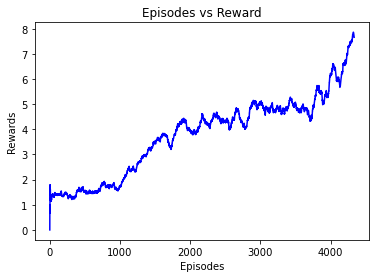

In [ ]:
pylab.plot(episodes, rewards, 'b')
pylab.xlabel('Episodes')
pylab.ylabel('Rewards')
pylab.title('Episodes vs Reward')
pylab.savefig("./save_graph/breakout_dqn_lstm.png") # save graph for training visualization

# Visualize Agent Performance

In [ ]:
torch.save(agent.policy_net, "./save_model/breakout_dqn_lstm_latest.pth")

In [ ]:
from gym.wrappers import RecordVideo # If importing monitor raises issues, try using `from gym.wrappers import RecordVideo`
import glob
import io
import base64

from IPython.display import HTML
from IPython import display as ipythondisplay

from pyvirtualdisplay import Display

env = gym.make('BreakoutDeterministic-v4', render_mode='rgb_array')
state = env.reset()
number_lives = find_max_lives(env)
state_size = env.observation_space.shape
action_size = 3 #fire, left, and right

# Displaying the game live
def show_state(env, step=0, info=""):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("%s | Step: %d %s" % ("Agent Playing",step, info))
    plt.axis('off')

    ipythondisplay.clear_output(wait=True)
    ipythondisplay.display(plt.gcf())

# Recording the game and replaying the game afterwards
def show_video():
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video style="height: 400px;" controls="" loop="" autoplay="" alt="test">
                <source type="video/mp4" src="data:video/mp4;base64,{0}">
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")


def wrap_env(env):
    env = RecordVideo(env, './video')
    return env

In [ ]:
# display = Display(visible=0, size=(300, 200))
# display.start()
HISTORY_SIZE = 1

# Load agent
agent.load_policy_net("./save_model/breakout_dqn_lstm_latest.pth")
agent.epsilon = 0.0 # Set agent to only exploit the best action

env = gym.make('BreakoutDeterministic-v4', render_mode='rgb_array')
env = wrap_env(env)

done = False
score = 0
step = 0
state, _ = env.reset()
next_state = state
life = number_lives
history = np.zeros([HISTORY_SIZE + 1, 84, 84], dtype=np.uint8)
get_init_state(history, state, HISTORY_SIZE)
frame = 0
hidden = None

while not done:

    # Render breakout
#     env.render()
#     show_state(env,step) # uncommenting this provides another way to visualize the game

    step += 1
    frame += 1

    # Perform a fire action if ball is no longer on screen
    if step > 1 and len(np.unique(next_state[:189] == state[:189])) < 2:
        action = torch.tensor([[0]]).cuda()
    else:
        action, hidden = agent.get_action(np.float32(history[:1, :, :]) / 255., hidden)
    state = next_state

    next_state, reward, done, _, info = env.step(action + 1)

    frame_next_state = get_frame(next_state)
    history[1, :, :] = frame_next_state
    terminal_state = check_live(life, info['lives'])

    life = info['lives']
    r = np.clip(reward, -1, 1)
    r = reward

    # Store the transition in memory
    agent.memory.push(deepcopy(frame_next_state), action, r, terminal_state)
    # Start training after random sample generation
    score += reward

    history[:1, :, :] = history[1:, :, :]
env.close()
show_video()
# display.stop()

# Save as PDF

In [1]:
%%capture

from google.colab import drive
drive.mount('/content/drive')
# install tex; first run may take several minutes
! apt-get install texlive-xetex
# file path and save location below are default; please change if they do not match yours
! jupyter nbconvert --output-dir='/content/drive/MyDrive/' '/content/drive/MyDrive/CS444/assignment5/MP5_DQNLSTM_EC.ipynb' --to pdf